## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [1]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
%matplotlib inline
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

import warnings

!pip install uszipcode

In [2]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [3]:
data= pd.read_csv("data/kc_house_data.csv")
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.00,3,1.00,1180,5650,1.00,NaN,0.00,3,7,1180,0.0,1955,0.00,98178,47.51,-122.26,1340,5650
1,6414100192,12/9/2014,538000.00,3,2.25,2570,7242,2.00,0.00,0.00,3,7,2170,400.0,1951,1991.00,98125,47.72,-122.32,1690,7639
2,5631500400,2/25/2015,180000.00,2,1.00,770,10000,1.00,0.00,0.00,3,6,770,0.0,1933,NaN,98028,47.74,-122.23,2720,8062
3,2487200875,12/9/2014,604000.00,4,3.00,1960,5000,1.00,0.00,0.00,5,7,1050,910.0,1965,0.00,98136,47.52,-122.39,1360,5000
4,1954400510,2/18/2015,510000.00,3,2.00,1680,8080,1.00,0.00,0.00,3,8,1680,0.0,1987,0.00,98074,47.62,-122.05,1800,7503


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [5]:
# lets clean some DTypes
#cleaning Basement Sq feet

sqft_basement_list= []
for num in data['sqft_basement'].values:
    if num == '?':
        sqft_basement_list.append(np.nan)
    else:
        sqft_basement_list.append(float(num))
data['sqft_basement']= sqft_basement_list
#cleaning year renovated        
data['yr_renovated'] = data['yr_renovated'].fillna(0).astype(int)
data['yr_renovated'] = np.where(data['yr_renovated'] == 0, data['yr_built'], data['yr_renovated'])

#corrected 33 bedroom house to 3
data['bedrooms'].replace(33, 3, inplace=True)

In [6]:
data['waterfront'].replace(np.nan, 0, inplace =True)

In [7]:
data['view'].replace(np.nan, 0 , inplace =True)

In [8]:
#check houses with same long and lat and getting rid of duplicate records

lat_long = {}
for a, b in zip(data['lat'].values, data['long'].values):
    if (a, b) not in list(lat_long.keys()):
        lat_long[(a, b)] = 1
    else:
        lat_long[(a, b)] += 1
for item in list(lat_long.keys()):
    if lat_long[item] < 2:
        del lat_long[item]
for item in list(lat_long.keys()):
        dfx = data[(data.lat == item[0]) & (data.long == item[1])]
        for id_d in dfx['id'].values:
            if dfx.loc[dfx['id'] == id_d]['yr_built'].values[0] != max(dfx['yr_built'].values):
                data = data.drop([data.loc[data['id'] == id_d].index[0]])

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21312 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21312 non-null  int64  
 1   date           21312 non-null  object 
 2   price          21312 non-null  float64
 3   bedrooms       21312 non-null  int64  
 4   bathrooms      21312 non-null  float64
 5   sqft_living    21312 non-null  int64  
 6   sqft_lot       21312 non-null  int64  
 7   floors         21312 non-null  float64
 8   waterfront     21312 non-null  float64
 9   view           21312 non-null  float64
 10  condition      21312 non-null  int64  
 11  grade          21312 non-null  int64  
 12  sqft_above     21312 non-null  int64  
 13  sqft_basement  20861 non-null  float64
 14  yr_built       21312 non-null  int64  
 15  yr_renovated   21312 non-null  int64  
 16  zipcode        21312 non-null  int64  
 17  lat            21312 non-null  float64
 18  long  

In [10]:

#Converting zipcode to city
# we are getting a look at the data per city 
from uszipcode import SearchEngine, SimpleZipcode, Zipcode
search = SearchEngine()

def zip_lookup(x):
    city = search.by_zipcode(x).major_city
    return city if city else 'None'

data['City'] = data['zipcode'].apply(zip_lookup)

data["City"].value_counts()

Seattle          8792
Renton           1581
Bellevue         1396
Kent             1192
Kirkland          968
Redmond           967
Auburn            908
Sammamish         794
Federal Way       773
Issaquah          724
Maple Valley      582
Woodinville       470
Snoqualmie        307
Kenmore           280
Mercer Island     279
Enumclaw          231
North Bend        217
Bothell           195
Duvall            189
Carnation         122
Vashon            117
Black Diamond      99
Fall City          80
Medina             49
Name: City, dtype: int64

In [11]:
df_seattle = data[data['City'] == 'Seattle']

In [12]:
df_seattle.loc[df_seattle['price'].idxmin()]

id               40000362
date             5/6/2014
price            78000.00
bedrooms                2
bathrooms            1.00
sqft_living           780
sqft_lot            16344
floors               1.00
waterfront           0.00
view                 0.00
condition               1
grade                   5
sqft_above            780
sqft_basement        0.00
yr_built             1942
yr_renovated         1942
zipcode             98168
lat                 47.47
long              -122.28
sqft_living15        1700
sqft_lot15          10387
City              Seattle
Name: 15279, dtype: object

<AxesSubplot:xlabel='price', ylabel='Density'>

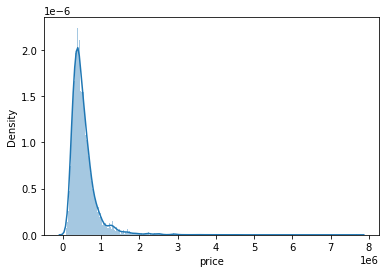

In [13]:
sns.distplot(a= df_seattle['price'], bins = 300)

In [14]:

data.loc[data["City"] == "Seattle", ["price"]]

,price
0,221900.00
1,538000.00
3,604000.00
7,291850.00
8,229500.00
...,...
21591,475000.00
21592,360000.00
21593,400000.00
21594,402101.00


In [15]:
cities = data['City']
Cities = cities.unique()

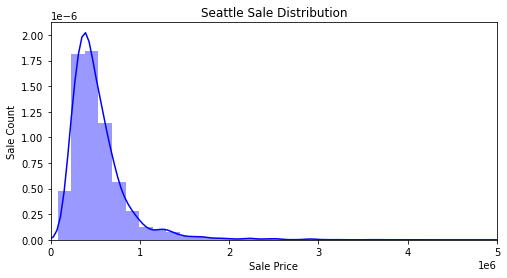

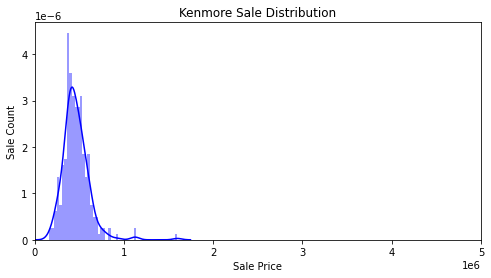

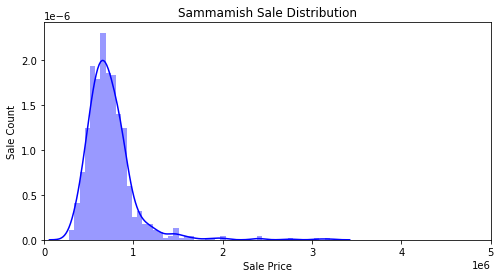

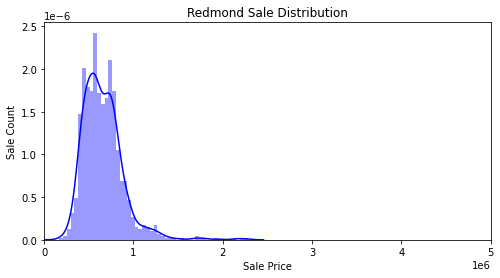

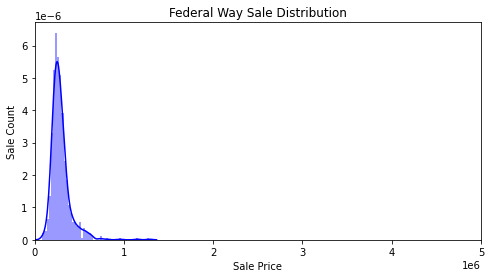

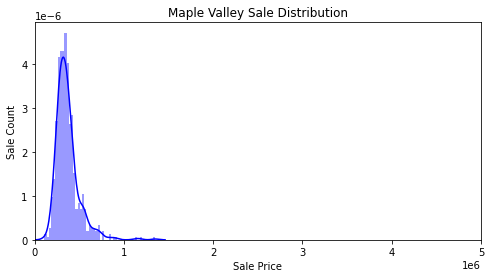

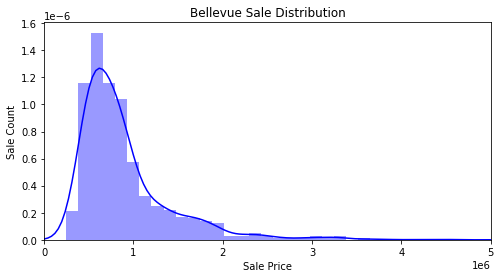

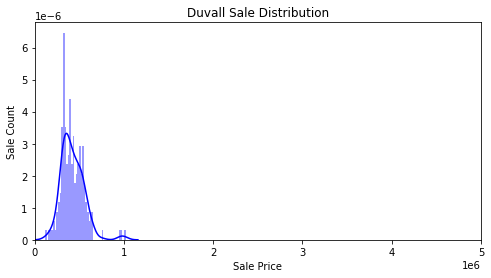

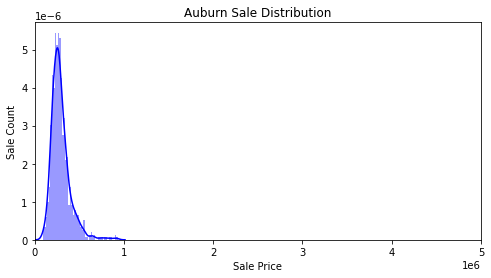

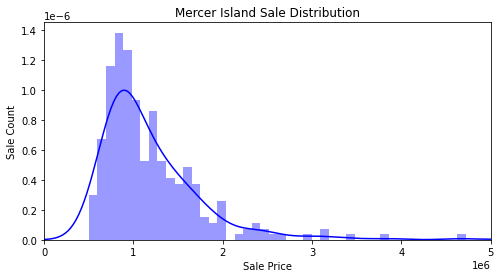

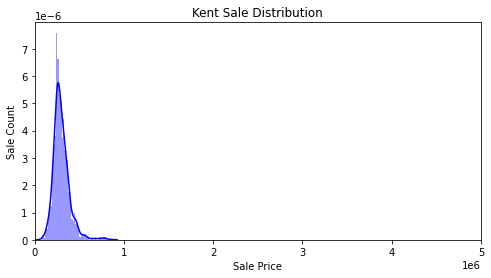

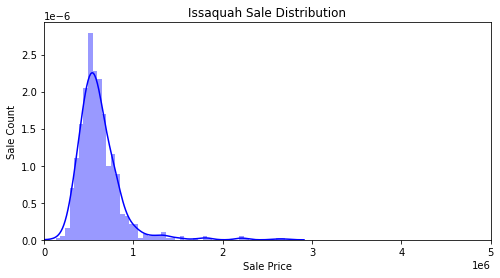

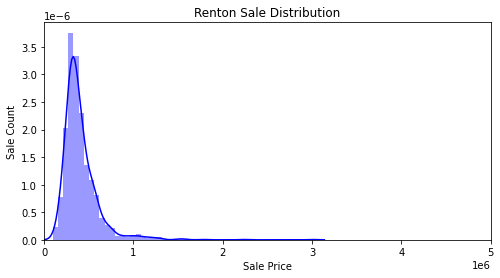

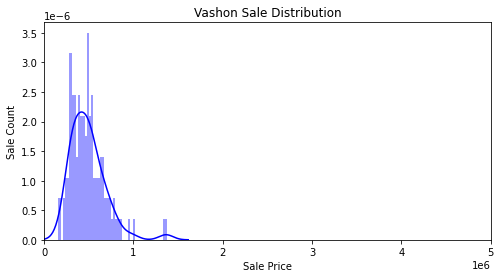

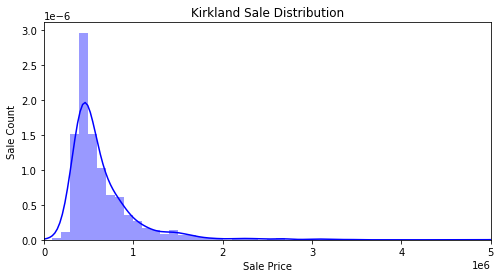

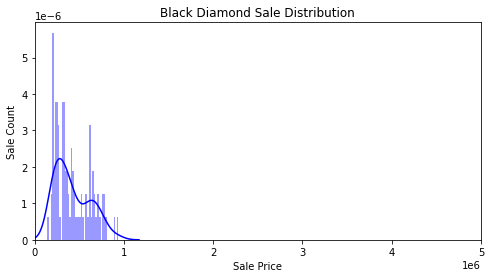

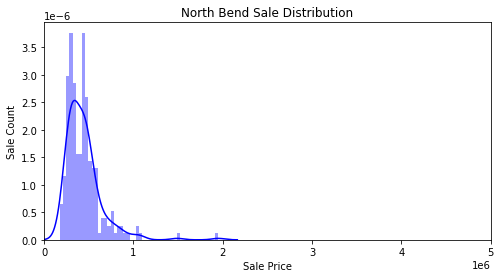

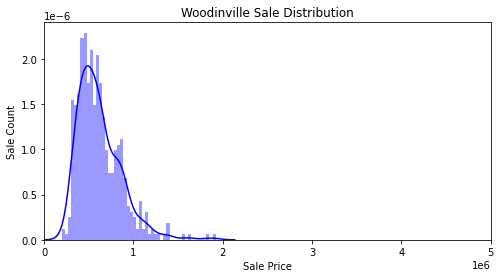

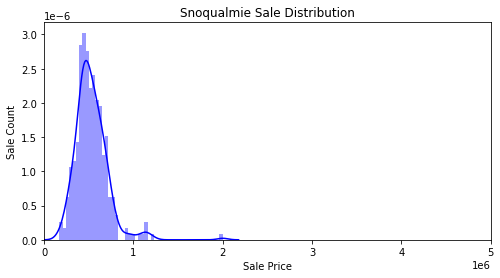

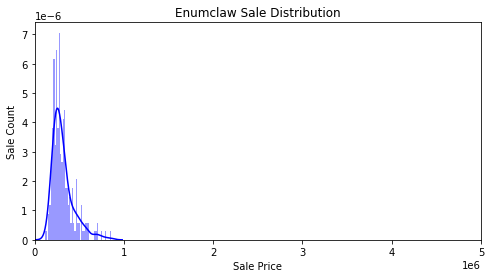

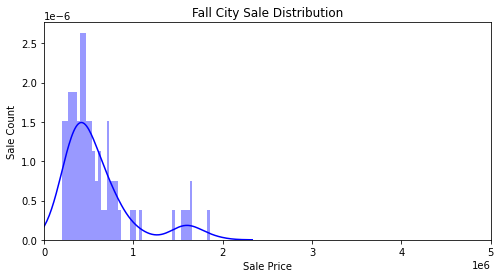

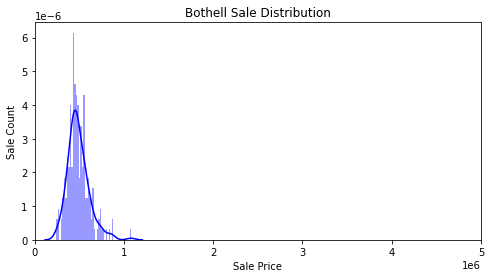

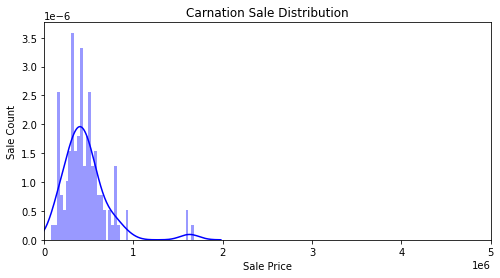

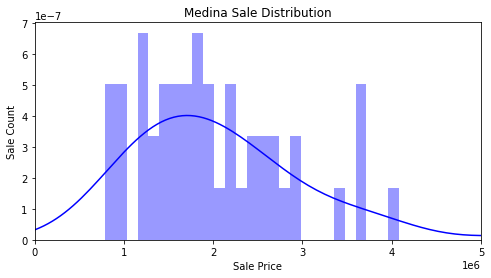

In [16]:


for city in Cities:
    
    fig, ax = plt.subplots(figsize = (8,4))
    sns.distplot(data.loc[data["City"] == city, ["price"]], bins=50, color = 'b')
    ax.set(xlim=[0, 5000000], xlabel='Sale Price', ylabel='Sale Count',
       title= f'{city} Sale Distribution')
    

In [17]:
mean_seattle = df_seattle['price'].mean()
mean_cities= []

In [18]:
for city in Cities:
    mean = data.loc[data["City"] == city, ["price"]].mean()
    print(city, mean)

Seattle price   535588.77
dtype: float64
Kenmore price   462740.54
dtype: float64
Sammamish price   732661.49
dtype: float64
Redmond price   658551.26
dtype: float64
Federal Way price   289635.99
dtype: float64
Maple Valley price   367852.13
dtype: float64
Bellevue price   899661.66
dtype: float64
Duvall price   425210.91
dtype: float64
Auburn price   291858.11
dtype: float64
Mercer Island price   1199537.51
dtype: float64
Kent price   299774.81
dtype: float64
Issaquah price   616349.17
dtype: float64
Renton price   404400.08
dtype: float64
Vashon price   489382.02
dtype: float64
Kirkland price   647613.47
dtype: float64
Black Diamond price   422187.87
dtype: float64
North Bend price   441351.31
dtype: float64
Woodinville price   617609.57
dtype: float64
Snoqualmie price   529882.65
dtype: float64
Enumclaw price   316250.98
dtype: float64
Fall City price   586120.88
dtype: float64
Bothell price   490377.11
dtype: float64
Carnation price   457760.02
dtype: float64
Medina price   2165612

In [19]:
control = np.array(df_seattle['price'])

In [20]:
Cities_no_seattle = Cities[1:]

#check to see which cities fall within the normal distribution with alpha level of 5%
for city in Cities_no_seattle:
    exp = np.array(data.loc[data["City"] == city]['price'])
    print(city, stats.ttest_ind(exp, control))
    
                

Kenmore Ttest_indResult(statistic=-3.558064537970104, pvalue=0.0003755056315598721)
Sammamish Ttest_indResult(statistic=15.784048965160062, pvalue=1.9930613694246708e-55)
Redmond Ttest_indResult(statistic=10.922052323525929, pvalue=1.3061998156185112e-27)
Federal Way Ttest_indResult(statistic=-19.932464896738697, pvalue=1.2046065055019629e-86)
Maple Valley Ttest_indResult(statistic=-11.788587449726565, pvalue=7.499262884763621e-32)
Bellevue Ttest_indResult(statistic=33.32547302477232, pvalue=3.188265203116826e-231)
Duvall Ttest_indResult(statistic=-4.43582247890187, pvalue=9.281374324402197e-06)
Auburn Ttest_indResult(statistic=-21.391828743906526, pvalue=3.0556555986423976e-99)
Mercer Island Ttest_indResult(statistic=30.94975692115126, pvalue=4.987318226237502e-200)
Kent Ttest_indResult(statistic=-23.721477999370023, pvalue=4.647421674340823e-121)
Issaquah Ttest_indResult(statistic=6.214561926527218, pvalue=5.36270143406931e-10)
Renton Ttest_indResult(statistic=-14.817266289985675, pv

In [21]:
# given alpha level of .05 we have decided to drop towns that were statistically different than Seattle given the data
dropped_cities= ["Vashon", "Snoqualmie", "Fall City", "Bothell"]

df_clean_city= data[~data['City'].isin(dropped_cities)]





In [22]:
# lets look at the heatmap and corr
df_clean_city.corr()


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.00,-0.02,-0.00,-0.01,-0.02,-0.13,0.00,0.01,0.01,-0.02,0.00,-0.03,0.00,0.01,0.01,-0.01,-0.00,-0.01,-0.02,-0.13
price,-0.02,1.00,0.32,0.53,0.70,0.08,0.26,0.29,0.40,0.04,0.67,0.61,0.33,0.05,0.10,-0.06,0.31,0.02,0.59,0.08
bedrooms,-0.00,0.32,1.00,0.53,0.59,0.05,0.18,0.02,0.09,0.03,0.37,0.49,0.31,0.16,0.17,-0.16,-0.02,0.13,0.40,0.05
bathrooms,-0.01,0.53,0.53,1.00,0.75,0.09,0.50,0.08,0.19,-0.12,0.66,0.68,0.29,0.50,0.53,-0.20,0.03,0.22,0.57,0.10
sqft_living,-0.02,0.70,0.59,0.75,1.00,0.18,0.35,0.12,0.29,-0.05,0.76,0.87,0.44,0.31,0.33,-0.20,0.05,0.24,0.75,0.19
sqft_lot,-0.13,0.08,0.05,0.09,0.18,1.00,-0.01,0.01,0.07,-0.01,0.12,0.19,0.02,0.05,0.05,-0.13,-0.08,0.27,0.16,0.72
floors,0.00,0.26,0.18,0.50,0.35,-0.01,1.00,0.03,0.03,-0.26,0.46,0.52,-0.24,0.49,0.50,-0.06,0.05,0.11,0.27,-0.01
waterfront,0.01,0.29,0.02,0.08,0.12,0.01,0.03,1.00,0.37,0.01,0.10,0.09,0.09,-0.02,-0.00,0.03,0.00,-0.02,0.10,0.02
view,0.01,0.40,0.09,0.19,0.29,0.07,0.03,0.37,1.00,0.05,0.25,0.17,0.28,-0.06,-0.03,0.09,0.02,-0.08,0.29,0.07
condition,-0.02,0.04,0.03,-0.12,-0.05,-0.01,-0.26,0.01,0.05,1.00,-0.15,-0.15,0.17,-0.36,-0.39,-0.00,-0.01,-0.09,-0.08,-0.01


In [23]:
#dropping non useful feature for our baseline regression
df_initial = df_clean_city.drop(['id', 'date' ], axis=1)
df_initial_r = df_clean_city.drop(['id', 'date', 'zipcode','price' ], axis=1)
Y= df_clean_city['price']

In [24]:
#scale our variables 
df_scaled_initial = (df_initial_r-np.mean(df_initial_r))/np.std(df_initial_r)

ss= StandardScaler()
ss.fit(df_initial_r.drop("City", axis=1))

StandardScaler()

In [25]:
df_initial

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,City
0,221900.00,3,1.00,1180,5650,1.00,0.00,0.00,3,7,1180,0.00,1955,1955,98178,47.51,-122.26,1340,5650,Seattle
1,538000.00,3,2.25,2570,7242,2.00,0.00,0.00,3,7,2170,400.00,1951,1991,98125,47.72,-122.32,1690,7639,Seattle
2,180000.00,2,1.00,770,10000,1.00,0.00,0.00,3,6,770,0.00,1933,1933,98028,47.74,-122.23,2720,8062,Kenmore
3,604000.00,4,3.00,1960,5000,1.00,0.00,0.00,5,7,1050,910.00,1965,1965,98136,47.52,-122.39,1360,5000,Seattle
4,510000.00,3,2.00,1680,8080,1.00,0.00,0.00,3,8,1680,0.00,1987,1987,98074,47.62,-122.05,1800,7503,Sammamish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.00,3,2.50,1530,1131,3.00,0.00,0.00,3,8,1530,0.00,2009,2009,98103,47.70,-122.35,1530,1509,Seattle
21593,400000.00,4,2.50,2310,5813,2.00,0.00,0.00,3,8,2310,0.00,2014,2014,98146,47.51,-122.36,1830,7200,Seattle
21594,402101.00,2,0.75,1020,1350,2.00,0.00,0.00,3,7,1020,0.00,2009,2009,98144,47.59,-122.30,1020,2007,Seattle
21595,400000.00,3,2.50,1600,2388,2.00,0.00,0.00,3,8,1600,0.00,2004,2004,98027,47.53,-122.07,1410,1287,Issaquah


In [26]:
df_scaled_initial

,City,bathrooms,bedrooms,condition,floors,grade,lat,long,sqft_above,sqft_basement,sqft_living,sqft_living15,sqft_lot,sqft_lot15,view,waterfront,yr_built,yr_renovated
0,NaN,-1.45,-0.41,-0.64,-0.90,-0.56,-0.34,-0.29,-0.73,-0.67,-0.98,-0.94,-0.23,-0.26,-0.30,-0.08,-0.54,-0.62
1,NaN,0.18,-0.41,-0.64,0.94,-0.56,1.16,-0.75,0.47,0.23,0.54,-0.42,-0.19,-0.18,-0.30,-0.08,-0.68,0.63
2,NaN,-1.45,-1.52,-0.64,-0.90,-1.41,1.28,-0.11,-1.22,-0.67,-1.42,1.08,-0.11,-0.16,-0.30,-0.08,-1.29,-1.38
3,NaN,1.15,0.69,2.43,-0.90,-0.56,-0.27,-1.30,-0.88,1.38,-0.13,-0.91,-0.24,-0.28,-0.30,-0.08,-0.20,-0.27
4,NaN,-0.15,-0.41,-0.64,-0.90,0.29,0.41,1.30,-0.12,-0.67,-0.43,-0.26,-0.16,-0.19,-0.30,-0.08,0.55,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,NaN,0.50,-0.41,-0.64,2.79,0.29,1.01,-0.95,-0.30,-0.67,-0.60,-0.66,-0.34,-0.42,-0.30,-0.08,1.31,1.26
21593,NaN,0.50,0.69,-0.64,0.94,0.29,-0.35,-1.07,0.64,-0.67,0.25,-0.22,-0.22,-0.20,-0.30,-0.08,1.48,1.43
21594,NaN,-1.77,-1.52,-0.64,0.94,-0.56,0.25,-0.60,-0.92,-0.67,-1.15,-1.41,-0.34,-0.40,-0.30,-0.08,1.31,1.26
21595,NaN,0.50,-0.41,-0.64,0.94,0.29,-0.18,1.12,-0.22,-0.67,-0.52,-0.83,-0.31,-0.43,-0.30,-0.08,1.14,1.09


In [27]:
# df_scaled2=ss.transform(df_initial_r.drop("City", axis=1))

In [28]:
# df_scaled2
df_scaled_initial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20613 entries, 0 to 21596
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   City           0 non-null      object 
 1   bathrooms      20613 non-null  float64
 2   bedrooms       20613 non-null  float64
 3   condition      20613 non-null  float64
 4   floors         20613 non-null  float64
 5   grade          20613 non-null  float64
 6   lat            20613 non-null  float64
 7   long           20613 non-null  float64
 8   sqft_above     20613 non-null  float64
 9   sqft_basement  20173 non-null  float64
 10  sqft_living    20613 non-null  float64
 11  sqft_living15  20613 non-null  float64
 12  sqft_lot       20613 non-null  float64
 13  sqft_lot15     20613 non-null  float64
 14  view           20613 non-null  float64
 15  waterfront     20613 non-null  float64
 16  yr_built       20613 non-null  float64
 17  yr_renovated   20613 non-null  float64
dtypes: flo

In [29]:
df_scaled_initial['sqft_basement'].fillna(0, inplace= True)

In [30]:

model = sm.OLS(Y, sm.add_constant(df_scaled_initial.drop("City", axis= 1))).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     2871.
Date:                Tue, 13 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:38:31   Log-Likelihood:            -2.8115e+05
No. Observations:               20613   AIC:                         5.623e+05
Df Residuals:                   20595   BIC:                         5.625e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.416e+05   1414.025    383.008      0.000    5.39e+05    5.44e+05
bathrooms      3.493e+04   2593.795     13.469      0.000    2.99e+04       4e+04
bedrooms      -3.526e+04   1843.191    -19.128      0.000   -3.89e+04   -3.16e+04
condition      2.056e+04   1573.227     13.068      0.000    1.75e+04    2.36e+04
floors         -908.9774   2000.584     -0.454      0.650   -4830.280    3012.325
grade          1.132e+05   2636.436     42.955      0.000    1.08e+05    1.18e+05
lat            7.912e+04   1501.734     52.689      0.000    7.62e+04    8.21e+04
long          -1.634e+04   1759.401     -9.289      0.000   -1.98e+04   -1.29e+04
sqft_above     8.119e+04   1.79e+04      4.538      0.000    4.61e+04    1.16e+05
sqft_basement  2.842e+04   9628.908      2.952      0.003    9547.520    4.73e+04
sqft_living    7.828e+04   1.99e+04      3.937      0.000    3.93e+04    1.17e+05
sqft_living15  2.037e+04   2425.051      8.399      0.000    1.56e+04    2.51e+04
sqft_lot       2528.7358   2042.085      1.238      0.216   -1473.913    6531.385
sqft_lot15    -1.121e+04   2067.793     -5.419      0.000   -1.53e+04   -7153.167
view           3.963e+04   1665.857     23.788      0.000    3.64e+04    4.29e+04
waterfront     5.505e+04   1526.069     36.075      0.000    5.21e+04     5.8e+04
yr_built      -9.451e+04   3862.444    -24.468      0.000   -1.02e+05   -8.69e+04
yr_renovated   2.244e+04   3914.456      5.733      0.000    1.48e+04    3.01e+04
==============================================================================
Omnibus:                    17380.077   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1674366.125
Skew:                           3.531   Prob(JB):                         0.00
Kurtosis:                      46.584   Cond. No.                         46.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
df_clean_city.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.00,-0.02,-0.00,-0.01,-0.02,-0.13,0.00,0.01,0.01,-0.02,0.00,-0.03,0.00,0.01,0.01,-0.01,-0.00,-0.01,-0.02,-0.13
price,-0.02,1.00,0.32,0.53,0.70,0.08,0.26,0.29,0.40,0.04,0.67,0.61,0.33,0.05,0.10,-0.06,0.31,0.02,0.59,0.08
bedrooms,-0.00,0.32,1.00,0.53,0.59,0.05,0.18,0.02,0.09,0.03,0.37,0.49,0.31,0.16,0.17,-0.16,-0.02,0.13,0.40,0.05
bathrooms,-0.01,0.53,0.53,1.00,0.75,0.09,0.50,0.08,0.19,-0.12,0.66,0.68,0.29,0.50,0.53,-0.20,0.03,0.22,0.57,0.10
sqft_living,-0.02,0.70,0.59,0.75,1.00,0.18,0.35,0.12,0.29,-0.05,0.76,0.87,0.44,0.31,0.33,-0.20,0.05,0.24,0.75,0.19
sqft_lot,-0.13,0.08,0.05,0.09,0.18,1.00,-0.01,0.01,0.07,-0.01,0.12,0.19,0.02,0.05,0.05,-0.13,-0.08,0.27,0.16,0.72
floors,0.00,0.26,0.18,0.50,0.35,-0.01,1.00,0.03,0.03,-0.26,0.46,0.52,-0.24,0.49,0.50,-0.06,0.05,0.11,0.27,-0.01
waterfront,0.01,0.29,0.02,0.08,0.12,0.01,0.03,1.00,0.37,0.01,0.10,0.09,0.09,-0.02,-0.00,0.03,0.00,-0.02,0.10,0.02
view,0.01,0.40,0.09,0.19,0.29,0.07,0.03,0.37,1.00,0.05,0.25,0.17,0.28,-0.06,-0.03,0.09,0.02,-0.08,0.29,0.07
condition,-0.02,0.04,0.03,-0.12,-0.05,-0.01,-0.26,0.01,0.05,1.00,-0.15,-0.15,0.17,-0.36,-0.39,-0.00,-0.01,-0.09,-0.08,-0.01


In [32]:
df_clean_city['bath_cond']= df_clean_city['bathrooms']*df_clean_city['condition']
df_clean_city['sqALL']= df_clean_city['sqft_living']*df_clean_city['yr_renovated']
df_clean_city['sqCOND']= df_clean_city['waterfront']*df_clean_city['bathrooms']
df_clean_city.corr()['price']

id              -0.02
price            1.00
bedrooms         0.32
bathrooms        0.53
sqft_living      0.70
sqft_lot         0.08
floors           0.26
waterfront       0.29
view             0.40
condition        0.04
grade            0.67
sqft_above       0.61
sqft_basement    0.33
yr_built         0.05
yr_renovated     0.10
zipcode         -0.06
lat              0.31
long             0.02
sqft_living15    0.59
sqft_lot15       0.08
bath_cond        0.51
sqALL            0.70
sqCOND           0.32
Name: price, dtype: float64

In [33]:
#assume NAN basement to be 0 sqft
df_clean_city["sqft_basement"]=df_clean_city["sqft_basement"].fillna(0)

<AxesSubplot:>

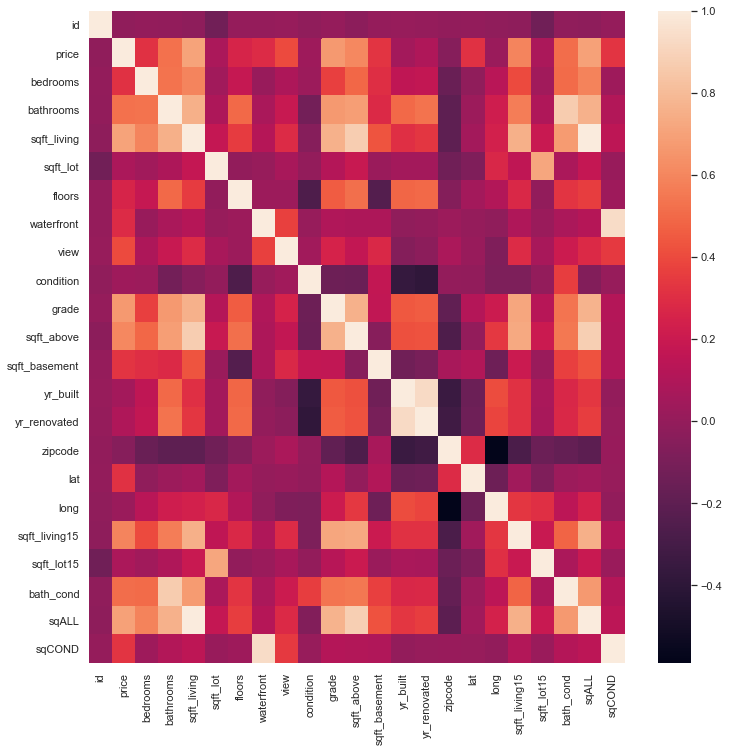

In [34]:
sns.set(rc={'figure.figsize':(12, 12)})
sns.heatmap(df_clean_city.corr())

#definetly some multi colinearlity going on here so we will need to explore this fact more later

In [35]:
# RFE
lr_rfe = LinearRegression()
select = RFE(lr_rfe, n_features_to_select=5)

In [36]:
df_scaled_initial.drop("City", axis=1, inplace=True)

In [37]:
select.fit(X=df_scaled_initial, y=df_clean_city['price'])

RFE(estimator=LinearRegression(), n_features_to_select=5)

In [38]:
select.support_

array([False, False, False, False,  True,  True, False, False, False,
        True, False, False, False, False,  True,  True, False])

In [39]:
df_scaled_initial

,bathrooms,bedrooms,condition,floors,grade,lat,long,sqft_above,sqft_basement,sqft_living,sqft_living15,sqft_lot,sqft_lot15,view,waterfront,yr_built,yr_renovated
0,-1.45,-0.41,-0.64,-0.90,-0.56,-0.34,-0.29,-0.73,-0.67,-0.98,-0.94,-0.23,-0.26,-0.30,-0.08,-0.54,-0.62
1,0.18,-0.41,-0.64,0.94,-0.56,1.16,-0.75,0.47,0.23,0.54,-0.42,-0.19,-0.18,-0.30,-0.08,-0.68,0.63
2,-1.45,-1.52,-0.64,-0.90,-1.41,1.28,-0.11,-1.22,-0.67,-1.42,1.08,-0.11,-0.16,-0.30,-0.08,-1.29,-1.38
3,1.15,0.69,2.43,-0.90,-0.56,-0.27,-1.30,-0.88,1.38,-0.13,-0.91,-0.24,-0.28,-0.30,-0.08,-0.20,-0.27
4,-0.15,-0.41,-0.64,-0.90,0.29,0.41,1.30,-0.12,-0.67,-0.43,-0.26,-0.16,-0.19,-0.30,-0.08,0.55,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0.50,-0.41,-0.64,2.79,0.29,1.01,-0.95,-0.30,-0.67,-0.60,-0.66,-0.34,-0.42,-0.30,-0.08,1.31,1.26
21593,0.50,0.69,-0.64,0.94,0.29,-0.35,-1.07,0.64,-0.67,0.25,-0.22,-0.22,-0.20,-0.30,-0.08,1.48,1.43
21594,-1.77,-1.52,-0.64,0.94,-0.56,0.25,-0.60,-0.92,-0.67,-1.15,-1.41,-0.34,-0.40,-0.30,-0.08,1.31,1.26
21595,0.50,-0.41,-0.64,0.94,0.29,-0.18,1.12,-0.22,-0.67,-0.52,-0.83,-0.31,-0.43,-0.30,-0.08,1.14,1.09


In [40]:
select.ranking_

array([ 3,  4,  8, 13,  1,  1, 10,  5,  6,  1,  9, 12, 11,  2,  1,  1,  7])

In [41]:
#grade, lat, sqftliving, yr_built, waterfront, 
#decided to replace waterfront with view because we didnt think waterfront would model well
#given the limitations of this data

In [42]:


df_second_r= df_scaled_initial[["grade", "lat", "sqft_living", "yr_built", "view", "waterfront"]]


In [43]:
df_second_r

,grade,lat,sqft_living,yr_built,view,waterfront
0,-0.56,-0.34,-0.98,-0.54,-0.30,-0.08
1,-0.56,1.16,0.54,-0.68,-0.30,-0.08
2,-1.41,1.28,-1.42,-1.29,-0.30,-0.08
3,-0.56,-0.27,-0.13,-0.20,-0.30,-0.08
4,0.29,0.41,-0.43,0.55,-0.30,-0.08
...,...,...,...,...,...,...
21592,0.29,1.01,-0.60,1.31,-0.30,-0.08
21593,0.29,-0.35,0.25,1.48,-0.30,-0.08
21594,-0.56,0.25,-1.15,1.31,-0.30,-0.08
21595,0.29,-0.18,-0.52,1.14,-0.30,-0.08


In [44]:

model2 = sm.OLS(Y, sm.add_constant(df_second_r)).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     7659.
Date:                Tue, 13 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:38:32   Log-Likelihood:            -2.8159e+05
No. Observations:               20613   AIC:                         5.632e+05
Df Residuals:                   20606   BIC:                         5.632e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.416e+05   1443.977    375.063      0.000    5.39e+05    5.44e+05
grade        1.357e+05   2443.075     55.546      0.000    1.31e+05     1.4e+05
lat           8.03e+04   1499.557     53.550      0.000    7.74e+04    8.32e+04
sqft_living  1.583e+05   2268.411     69.781      0.000    1.54e+05    1.63e+05
yr_built    -7.485e+04   1694.392    -44.175      0.000   -7.82e+04   -7.15e+04
view         4.343e+04   1642.022     26.452      0.000    4.02e+04    4.67e+04
waterfront   5.598e+04   1554.795     36.007      0.000    5.29e+04     5.9e+04
==============================================================================
Omnibus:                    17639.388   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1766070.958
Skew:                           3.608   Prob(JB):                         0.00
Kurtosis:                      47.768   Cond. No.                         3.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

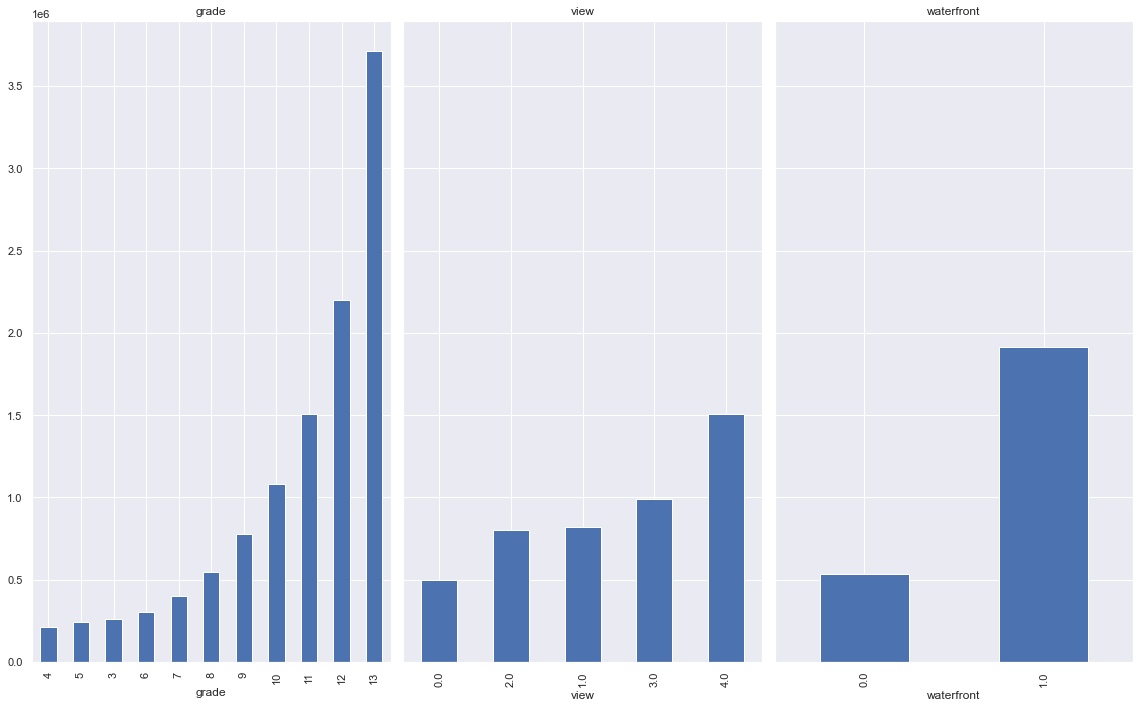

In [45]:
#lets look at our categorical variables and see if they are worth exploring further

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,10), sharey=True)

selected = ["grade", "view", "waterfront"]

for col, ax in zip(selected, axes.flatten()):
    (df_clean_city.groupby(col)               # group values together by column of interest
         .mean()['price']        # take the mean of the saleprice for each group
         .sort_values()              # sort the groups in ascending order
         .plot
         .bar(ax=ax))                # create a bar graph on the ax
    
    ax.set_title(col)                # Make the title the name of the column
    
fig.tight_layout()

In [46]:
#lets dummy the grade
grade_origin= df_clean_city['grade']

df_dummy_grade= pd.get_dummies(grade_origin, drop_first= True) #avoid dummy trap

df_second_r = pd.concat([df_dummy_grade, df_second_r], axis=1)

df_second_r

,4,5,6,7,8,9,10,11,12,13,grade,lat,sqft_living,yr_built,view,waterfront
0,0,0,0,1,0,0,0,0,0,0,-0.56,-0.34,-0.98,-0.54,-0.30,-0.08
1,0,0,0,1,0,0,0,0,0,0,-0.56,1.16,0.54,-0.68,-0.30,-0.08
2,0,0,1,0,0,0,0,0,0,0,-1.41,1.28,-1.42,-1.29,-0.30,-0.08
3,0,0,0,1,0,0,0,0,0,0,-0.56,-0.27,-0.13,-0.20,-0.30,-0.08
4,0,0,0,0,1,0,0,0,0,0,0.29,0.41,-0.43,0.55,-0.30,-0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0,0,0,0,1,0,0,0,0,0,0.29,1.01,-0.60,1.31,-0.30,-0.08
21593,0,0,0,0,1,0,0,0,0,0,0.29,-0.35,0.25,1.48,-0.30,-0.08
21594,0,0,0,1,0,0,0,0,0,0,-0.56,0.25,-1.15,1.31,-0.30,-0.08
21595,0,0,0,0,1,0,0,0,0,0,0.29,-0.18,-0.52,1.14,-0.30,-0.08


In [47]:
#rename cols
mapper = {4:'Grade 4', 5: 'Grade 5', 6:'Grade 6',7:'Grade 7',
          8:'Grade 8',9:'Grade 9',10:'Grade 10', 11:'Grade 11',12:'Grade 12',13:'Grade 13'}

df_second_r.rename(mapper=mapper, axis=1, inplace= True)

In [48]:
# df_second_r.drop('grade', axis=1, inplace=True)

In [49]:
df_second_r

,Grade 4,Grade 5,Grade 6,Grade 7,Grade 8,Grade 9,Grade 10,Grade 11,Grade 12,Grade 13,grade,lat,sqft_living,yr_built,view,waterfront
0,0,0,0,1,0,0,0,0,0,0,-0.56,-0.34,-0.98,-0.54,-0.30,-0.08
1,0,0,0,1,0,0,0,0,0,0,-0.56,1.16,0.54,-0.68,-0.30,-0.08
2,0,0,1,0,0,0,0,0,0,0,-1.41,1.28,-1.42,-1.29,-0.30,-0.08
3,0,0,0,1,0,0,0,0,0,0,-0.56,-0.27,-0.13,-0.20,-0.30,-0.08
4,0,0,0,0,1,0,0,0,0,0,0.29,0.41,-0.43,0.55,-0.30,-0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0,0,0,0,1,0,0,0,0,0,0.29,1.01,-0.60,1.31,-0.30,-0.08
21593,0,0,0,0,1,0,0,0,0,0,0.29,-0.35,0.25,1.48,-0.30,-0.08
21594,0,0,0,1,0,0,0,0,0,0,-0.56,0.25,-1.15,1.31,-0.30,-0.08
21595,0,0,0,0,1,0,0,0,0,0,0.29,-0.18,-0.52,1.14,-0.30,-0.08


In [50]:

model3 = sm.OLS(Y, sm.add_constant(df_second_r)).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     3517.
Date:                Tue, 13 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:38:32   Log-Likelihood:            -2.8058e+05
No. Observations:               20613   AIC:                         5.612e+05
Df Residuals:                   20597   BIC:                         5.613e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        9.657e+05   6.33e+04     15.254      0.000    8.42e+05    1.09e+06
Grade 4     -2.927e+05   1.73e+05     -1.692      0.091   -6.32e+05    4.64e+04
Grade 5      -3.88e+05    1.4e+05     -2.763      0.006   -6.63e+05   -1.13e+05
Grade 6     -4.393e+05   1.11e+05     -3.955      0.000   -6.57e+05   -2.22e+05
Grade 7     -4.565e+05   8.23e+04     -5.549      0.000   -6.18e+05   -2.95e+05
Grade 8     -4.465e+05   5.37e+04     -8.310      0.000   -5.52e+05   -3.41e+05
Grade 9     -3.902e+05   2.61e+04    -14.957      0.000   -4.41e+05   -3.39e+05
Grade 10    -2.989e+05   1.23e+04    -24.227      0.000   -3.23e+05   -2.75e+05
Grade 11    -1.135e+05   3.64e+04     -3.119      0.002   -1.85e+05   -4.22e+04
Grade 12     2.621e+05   6.58e+04      3.981      0.000    1.33e+05    3.91e+05
Grade 13     1.403e+06      1e+05     13.972      0.000    1.21e+06     1.6e+06
grade        8.824e+04    3.4e+04      2.596      0.009    2.16e+04    1.55e+05
lat          8.307e+04   1430.778     58.057      0.000    8.03e+04    8.59e+04
sqft_living  1.399e+05   2201.119     63.565      0.000    1.36e+05    1.44e+05
yr_built    -6.307e+04   1648.792    -38.250      0.000   -6.63e+04   -5.98e+04
view         4.135e+04   1566.044     26.405      0.000    3.83e+04    4.44e+04
waterfront   5.406e+04   1484.867     36.405      0.000    5.11e+04     5.7e+04
==============================================================================
Omnibus:                    13599.310   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           645162.494
Skew:                           2.572   Prob(JB):                         0.00
Kurtosis:                      29.921   Cond. No.                     1.35e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.6e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [51]:
df_clean_city['grade'].value_counts().sort_values()

3        1
13      13
4       26
12      86
5      221
11     387
10    1101
6     1933
9     2460
8     5806
7     8579
Name: grade, dtype: int64

In [52]:
df_dropped_grade = df_second_r.drop(["Grade 13", "Grade 12", "Grade 4"], axis=1)


In [53]:
model4 = sm.OLS(Y, sm.add_constant(df_dropped_grade)).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     3971.
Date:                Tue, 13 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:38:32   Log-Likelihood:            -2.8074e+05
No. Observations:               20613   AIC:                         5.615e+05
Df Residuals:                   20599   BIC:                         5.616e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        9.741e+05   2.29e+04     42.523      0.000    9.29e+05    1.02e+06
Grade 5     -1.503e+05    3.6e+04     -4.172      0.000   -2.21e+05   -7.97e+04
Grade 6     -2.937e+05   2.95e+04     -9.953      0.000   -3.52e+05   -2.36e+05
Grade 7     -4.035e+05   2.53e+04    -15.936      0.000   -4.53e+05   -3.54e+05
Grade 8     -4.861e+05    2.2e+04    -22.061      0.000   -5.29e+05   -4.43e+05
Grade 9      -5.23e+05   1.98e+04    -26.478      0.000   -5.62e+05   -4.84e+05
Grade 10    -5.248e+05    1.9e+04    -27.653      0.000   -5.62e+05   -4.88e+05
Grade 11     -4.33e+05   2.07e+04    -20.870      0.000   -4.74e+05   -3.92e+05
grade         1.96e+05   6466.759     30.307      0.000    1.83e+05    2.09e+05
lat          8.306e+04   1441.716     57.613      0.000    8.02e+04    8.59e+04
sqft_living  1.422e+05   2214.497     64.207      0.000    1.38e+05    1.47e+05
yr_built    -6.369e+04   1661.185    -38.340      0.000   -6.69e+04   -6.04e+04
view         4.147e+04   1578.159     26.275      0.000    3.84e+04    4.46e+04
waterfront   5.293e+04   1495.013     35.405      0.000       5e+04    5.59e+04
==============================================================================
Omnibus:                    14966.051   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1041913.398
Skew:                           2.855   Prob(JB):                         0.00
Kurtosis:                      37.359   Cond. No.                         70.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
#dummying the view 
view_origin= df_clean_city['view']

df_dummy_view= pd.get_dummies(view_origin, drop_first= True)
df_second_r = pd.concat([df_dummy_view, df_second_r], axis=1)

In [55]:
df_second_r
mapper_view = {4.0:'View 4', 2.0: 'View 2', 3.0:'View 3',1.0:'View 1'}

df_second_r.rename(mapper=mapper_view, axis=1, inplace= True)

In [56]:
df_second_r

,View 1,View 2,View 3,View 4,Grade 4,Grade 5,Grade 6,Grade 7,Grade 8,Grade 9,Grade 10,Grade 11,Grade 12,Grade 13,grade,lat,sqft_living,yr_built,view,waterfront
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-0.56,-0.34,-0.98,-0.54,-0.30,-0.08
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-0.56,1.16,0.54,-0.68,-0.30,-0.08
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,-1.41,1.28,-1.42,-1.29,-0.30,-0.08
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-0.56,-0.27,-0.13,-0.20,-0.30,-0.08
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.29,0.41,-0.43,0.55,-0.30,-0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.29,1.01,-0.60,1.31,-0.30,-0.08
21593,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.29,-0.35,0.25,1.48,-0.30,-0.08
21594,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-0.56,0.25,-1.15,1.31,-0.30,-0.08
21595,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.29,-0.18,-0.52,1.14,-0.30,-0.08


In [57]:
df_4 = df_second_r.drop(["grade", "view"], axis=1)
model4 = sm.OLS(Y, sm.add_constant(df_4)).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     2946.
Date:                Tue, 13 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:38:32   Log-Likelihood:            -2.8054e+05
No. Observations:               20613   AIC:                         5.611e+05
Df Residuals:                   20594   BIC:                         5.613e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.015e+05   1.97e+05      3.050      0.002    2.15e+05    9.88e+05
View 1       1.284e+05   1.12e+04     11.471      0.000    1.06e+05     1.5e+05
View 2       7.902e+04   6854.985     11.528      0.000    6.56e+04    9.25e+04
View 3       1.576e+05   9391.008     16.784      0.000    1.39e+05    1.76e+05
View 4       2.727e+05   1.45e+04     18.852      0.000    2.44e+05    3.01e+05
Grade 4     -2.216e+05   2.01e+05     -1.103      0.270   -6.15e+05    1.72e+05
Grade 5     -2.372e+05   1.98e+05     -1.200      0.230   -6.24e+05     1.5e+05
Grade 6      -2.13e+05   1.97e+05     -1.080      0.280      -6e+05    1.74e+05
Grade 7      -1.55e+05   1.97e+05     -0.786      0.432   -5.42e+05    2.32e+05
Grade 8     -6.965e+04   1.97e+05     -0.353      0.724   -4.56e+05    3.17e+05
Grade 9      6.152e+04   1.97e+05      0.312      0.755   -3.25e+05    4.48e+05
Grade 10     2.282e+05   1.97e+05      1.156      0.248   -1.59e+05    6.15e+05
Grade 11     4.893e+05   1.98e+05      2.475      0.013    1.02e+05    8.77e+05
Grade 12     9.367e+05   1.99e+05      4.713      0.000    5.47e+05    1.33e+06
Grade 13     2.154e+06   2.05e+05     10.487      0.000    1.75e+06    2.56e+06
lat          8.282e+04   1428.678     57.968      0.000       8e+04    8.56e+04
sqft_living  1.395e+05   2198.754     63.450      0.000    1.35e+05    1.44e+05
yr_built    -6.298e+04   1648.452    -38.204      0.000   -6.62e+04   -5.97e+04
waterfront    5.04e+04   1695.608     29.721      0.000    4.71e+04    5.37e+04
==============================================================================
Omnibus:                    13651.149   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           669722.641
Skew:                           2.576   Prob(JB):                         0.00
Kurtosis:                      30.445   Cond. No.                         570.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
print(df_initial['bedrooms'].value_counts().sort_values())
print(df_initial['sqft_living'].value_counts().sort_values())
print(df_initial['yr_built'].value_counts().sort_values())

df_initial.describe()

11       1
10       3
9        6
8       12
7       38
1      179
6      260
5     1520
2     2628
4     6605
3     9361
Name: bedrooms, dtype: int64
2031      1
7440      1
3362      1
1315      1
1347      1
       ... 
1820    124
1660    126
1300    130
1400    130
1440    131
Name: sqft_living, Length: 1005, dtype: int64
1934     18
1935     22
1902     25
1901     27
1933     29
       ... 
2003    395
1977    395
2006    415
2005    429
2014    537
Name: yr_built, Length: 116, dtype: int64


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,20613.00,20613.00,20613.00,20613.00,20613.00,20613.00,20613.00,20613.00,20613.00,20613.00,20613.00,20173.00,20613.00,20613.00,20613.00,20613.00,20613.00,20613.00,20613.00
mean,541582.60,3.37,2.11,2076.15,14419.53,1.49,0.01,0.23,3.42,7.66,1780.00,296.26,1970.79,1972.72,98078.82,47.56,-122.22,1980.17,12260.08
std,372539.02,0.90,0.77,917.76,38640.66,0.54,0.08,0.76,0.65,1.17,825.22,444.70,29.21,28.80,53.93,0.14,0.13,682.90,25595.12
min,78000.00,1.00,0.50,370.00,520.00,1.00,0.00,0.00,1.00,3.00,370.00,0.00,1900.00,1900.00,98001.00,47.16,-122.42,399.00,651.00
25%,320000.00,3.00,1.50,1420.00,5040.00,1.00,0.00,0.00,3.00,7.00,1190.00,0.00,1951.00,1954.00,98033.00,47.47,-122.33,1480.00,5100.00
50%,450000.00,3.00,2.25,1910.00,7605.00,1.00,0.00,0.00,3.00,7.00,1550.00,0.00,1974.00,1977.00,98072.00,47.57,-122.24,1830.00,7620.00
75%,649950.00,4.00,2.50,2540.00,10584.00,2.00,0.00,0.00,4.00,8.00,2190.00,580.00,1996.00,1998.00,98118.00,47.68,-122.13,2350.00,10042.00
max,7700000.00,11.00,8.00,13540.00,1651359.00,3.50,1.00,4.00,5.00,13.00,9410.00,4820.00,2015.00,2015.00,98199.00,47.78,-121.31,6210.00,871200.00


In [59]:
df_second_r['age'] = 2021 - df_initial['yr_built']
df_second_r['renovated'] = np.where(df_initial['yr_renovated']>0,1,0)

In [60]:
df_second_r.drop("grade", axis=1, inplace= True)

In [61]:

model4 = sm.OLS(Y, sm.add_constant(df_second_r)).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     2946.
Date:                Tue, 13 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:38:32   Log-Likelihood:            -2.8054e+05
No. Observations:               20613   AIC:                         5.611e+05
Df Residuals:                   20594   BIC:                         5.613e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
View 1       6.885e+04   1.09e+04      6.288      0.000    4.74e+04    9.03e+04
View 2      -4.008e+04   7118.697     -5.630      0.000    -5.4e+04   -2.61e+04
View 3      -2.103e+04   8651.973     -2.431      0.015    -3.8e+04   -4070.069
View 4       3.453e+04   8059.245      4.285      0.000    1.87e+04    5.03e+04
Grade 4     -2.216e+05   2.01e+05     -1.103      0.270   -6.15e+05    1.72e+05
Grade 5     -2.372e+05   1.98e+05     -1.200      0.230   -6.24e+05     1.5e+05
Grade 6      -2.13e+05   1.97e+05     -1.080      0.280      -6e+05    1.74e+05
Grade 7      -1.55e+05   1.97e+05     -0.786      0.432   -5.42e+05    2.32e+05
Grade 8     -6.965e+04   1.97e+05     -0.353      0.724   -4.56e+05    3.17e+05
Grade 9      6.152e+04   1.97e+05      0.312      0.755   -3.25e+05    4.48e+05
Grade 10     2.282e+05   1.97e+05      1.156      0.248   -1.59e+05    6.15e+05
Grade 11     4.893e+05   1.98e+05      2.475      0.013    1.02e+05    8.77e+05
Grade 12     9.367e+05   1.99e+05      4.713      0.000    5.47e+05    1.33e+06
Grade 13     2.154e+06   2.05e+05     10.487      0.000    1.75e+06    2.56e+06
lat          8.282e+04   1428.678     57.968      0.000       8e+04    8.56e+04
sqft_living  1.395e+05   2198.754     63.450      0.000    1.35e+05    1.44e+05
yr_built     2.202e+05   8.57e+04      2.570      0.010    5.23e+04    3.88e+05
view         4.516e+04   1759.728     25.663      0.000    4.17e+04    4.86e+04
waterfront    5.04e+04   1695.608     29.721      0.000    4.71e+04    5.37e+04
age          9697.6974   2932.506      3.307      0.001    3949.754    1.54e+04
renovated    1.283e+05   4.99e+04      2.571      0.010    3.05e+04    2.26e+05
==============================================================================
Omnibus:                    13651.149   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           669722.641
Skew:                           2.576   Prob(JB):                         0.00
Kurtosis:                      30.445   Cond. No.                     4.08e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.18e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [62]:

kc_top5_price = df_initial.groupby("zipcode")["price"].mean().sort_values(ascending = False)[:25]

In [63]:
df_anova= df_initial.drop("City", axis=1)

In [64]:
kc_top5_price

zipcode
98039   2165612.24
98004   1359578.61
98040   1199537.51
98112   1091591.33
98102    902772.48
98109    885844.10
98105    868759.85
98006    859938.55
98119    852674.58
98005    811824.37
98033    807136.23
98199    795258.96
98075    790010.56
98074    686049.01
98077    682885.99
98177    678035.36
98053    677924.18
98008    646787.77
98052    644767.34
98122    633311.13
98115    621757.98
98116    619787.11
98007    619436.76
98027    619230.81
98029    612690.66
Name: price, dtype: float64

In [65]:

#running anova to see if zipcodes with highest prices are statistically significant
# alpha = 0.05 
# kc_top5 = df_anova[df_anova.zipcode.isin(kc_top5_price.index)]
# formula = 'price~C(zipcode)'
# lm_top5 = sm.ols(formula, kc_top5).fit()
# anova_top5_table = sm.stats.anova_lm(lm_top5, typ=2)
# if anova_top5_table["PR(>F)"][0] < alpha:
#     print("Top 5 ranked zipcode have a statistically significant impact on average property value")
#     print("Zipcode ANOVA F-statisic Probability: ", anova_top5_table["PR(>F)"][0])

In [66]:
df_second_r.drop('view', axis=1)

,View 1,View 2,View 3,View 4,Grade 4,Grade 5,Grade 6,Grade 7,Grade 8,Grade 9,Grade 10,Grade 11,Grade 12,Grade 13,lat,sqft_living,yr_built,waterfront,age,renovated
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-0.34,-0.98,-0.54,-0.08,66,1
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.16,0.54,-0.68,-0.08,70,1
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1.28,-1.42,-1.29,-0.08,88,1
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-0.27,-0.13,-0.20,-0.08,56,1
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.41,-0.43,0.55,-0.08,34,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.01,-0.60,1.31,-0.08,12,1
21593,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.35,0.25,1.48,-0.08,7,1
21594,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.25,-1.15,1.31,-0.08,12,1
21595,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.18,-0.52,1.14,-0.08,17,1


In [67]:
#added a feature of wether the home is in a top 25 zipcode
zipcode_index = kc_top5_price.index
df_second_r['top25_neighborhood'] = df_initial['zipcode'].isin(zipcode_index).astype(int)

In [68]:
df_second_r

,View 1,View 2,View 3,View 4,Grade 4,Grade 5,Grade 6,Grade 7,Grade 8,Grade 9,Grade 10,Grade 11,Grade 12,Grade 13,lat,sqft_living,yr_built,view,waterfront,age,renovated,top25_neighborhood
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-0.34,-0.98,-0.54,-0.30,-0.08,66,1,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.16,0.54,-0.68,-0.30,-0.08,70,1,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1.28,-1.42,-1.29,-0.30,-0.08,88,1,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-0.27,-0.13,-0.20,-0.30,-0.08,56,1,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.41,-0.43,0.55,-0.30,-0.08,34,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.01,-0.60,1.31,-0.30,-0.08,12,1,0
21593,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.35,0.25,1.48,-0.30,-0.08,7,1,0
21594,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.25,-1.15,1.31,-0.30,-0.08,12,1,0
21595,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.18,-0.52,1.14,-0.30,-0.08,17,1,1


In [69]:
model4 = sm.OLS(Y, sm.add_constant(df_second_r)).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     3227.
Date:                Tue, 13 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:38:32   Log-Likelihood:            -2.7945e+05
No. Observations:               20613   AIC:                         5.589e+05
Df Residuals:                   20593   BIC:                         5.591e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
View 1              6.397e+04   1.04e+04      6.162      0.000    4.36e+04    8.43e+04
View 2             -3.931e+04   6749.919     -5.824      0.000   -5.25e+04   -2.61e+04
View 3             -1.632e+04   8204.326     -1.989      0.047   -3.24e+04    -238.612
View 4              3.161e+04   7641.962      4.136      0.000    1.66e+04    4.66e+04
Grade 4            -1.954e+05    1.9e+05     -1.026      0.305   -5.69e+05    1.78e+05
Grade 5             -2.02e+05   1.87e+05     -1.078      0.281   -5.69e+05    1.65e+05
Grade 6            -1.815e+05   1.87e+05     -0.971      0.332   -5.48e+05    1.85e+05
Grade 7            -1.423e+05   1.87e+05     -0.761      0.447   -5.09e+05    2.24e+05
Grade 8            -8.553e+04   1.87e+05     -0.457      0.647   -4.52e+05    2.81e+05
Grade 9             2.119e+04   1.87e+05      0.113      0.910   -3.46e+05    3.88e+05
Grade 10            1.672e+05   1.87e+05      0.893      0.372      -2e+05    5.34e+05
Grade 11            4.285e+05   1.87e+05      2.286      0.022    6.11e+04    7.96e+05
Grade 12            8.624e+05   1.88e+05      4.576      0.000    4.93e+05    1.23e+06
Grade 13            2.089e+06   1.95e+05     10.728      0.000    1.71e+06    2.47e+06
lat                 5.966e+04   1437.667     41.501      0.000    5.68e+04    6.25e+04
sqft_living         1.364e+05   2085.865     65.379      0.000    1.32e+05     1.4e+05
yr_built            2.045e+05   8.12e+04      2.517      0.012    4.53e+04    3.64e+05
view                4.674e+04   1668.885     28.006      0.000    4.35e+04       5e+04
waterfront          5.202e+04   1608.120     32.350      0.000    4.89e+04    5.52e+04
age                 8893.4831   2780.632      3.198      0.001    3443.224    1.43e+04
renovated           1.191e+05   4.73e+04      2.518      0.012    2.64e+04    2.12e+05
top25_neighborhood  1.519e+05   3157.772     48.092      0.000    1.46e+05    1.58e+05
==============================================================================
Omnibus:                    14977.895   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           959179.636
Skew:                           2.887   Prob(JB):                         0.00
Kurtosis:                      35.916   Cond. No.                     2.12e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.54e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [70]:
#lets add grade back into the mix

df_second_r['condition']= df_initial['condition']

In [71]:
df_second_r['condition'].value_counts().sort_values()

1       26
2      158
5     1649
4     5472
3    13308
Name: condition, dtype: int64

In [72]:
#making dummy for condition
condition_origin= df_second_r['condition']
df_cond_dum=pd.get_dummies(condition_origin, drop_first=True)
df_second_r= pd.concat([df_cond_dum, df_second_r], axis=1)

In [73]:
mapper3 = {1:'Condition 1',2:'Condition 2',3:'Condition 3',4:'Condition 4',5:'Condition 5'}
df_second_r.rename(mapper=mapper3, axis=1, inplace=True)

In [74]:
df_second_r.drop("condition", axis=1, inplace=True)

In [75]:
model4 = sm.OLS(Y, sm.add_constant(df_second_r)).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     2693.
Date:                Tue, 13 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:38:33   Log-Likelihood:            -2.7936e+05
No. Observations:               20613   AIC:                         5.588e+05
Df Residuals:                   20589   BIC:                         5.590e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Condition 2         7.269e+04   3.96e+04      1.837      0.066   -4851.855     1.5e+05
Condition 3         9.274e+04   3.69e+04      2.513      0.012    2.04e+04    1.65e+05
Condition 4         1.076e+05   3.69e+04      2.916      0.004    3.53e+04     1.8e+05
Condition 5         1.555e+05   3.71e+04      4.191      0.000    8.27e+04    2.28e+05
View 1              6.434e+04   1.03e+04      6.221      0.000    4.41e+04    8.46e+04
View 2              -3.93e+04   6728.398     -5.841      0.000   -5.25e+04   -2.61e+04
View 3             -1.535e+04   8179.368     -1.876      0.061   -3.14e+04     686.708
View 4              2.879e+04   7617.040      3.779      0.000    1.39e+04    4.37e+04
Grade 4            -1.367e+05    1.9e+05     -0.720      0.471   -5.09e+05    2.35e+05
Grade 5            -1.521e+05   1.87e+05     -0.815      0.415   -5.18e+05    2.14e+05
Grade 6             -1.36e+05   1.86e+05     -0.730      0.465   -5.01e+05    2.29e+05
Grade 7            -9.867e+04   1.86e+05     -0.530      0.596   -4.64e+05    2.67e+05
Grade 8             -4.12e+04   1.86e+05     -0.221      0.825   -4.06e+05    3.24e+05
Grade 9             6.742e+04   1.86e+05      0.362      0.718   -2.98e+05    4.33e+05
Grade 10            2.153e+05   1.87e+05      1.154      0.248    -1.5e+05    5.81e+05
Grade 11            4.793e+05   1.87e+05      2.566      0.010    1.13e+05    8.45e+05
Grade 12            9.162e+05   1.88e+05      4.879      0.000    5.48e+05    1.28e+06
Grade 13            2.153e+06   1.94e+05     11.093      0.000    1.77e+06    2.53e+06
lat                 6.071e+04   1443.300     42.060      0.000    5.79e+04    6.35e+04
sqft_living         1.342e+05   2085.136     64.370      0.000     1.3e+05    1.38e+05
yr_built            1.457e+05   8.25e+04      1.766      0.077    -1.6e+04    3.07e+05
view                4.659e+04   1664.495     27.991      0.000    4.33e+04    4.99e+04
waterfront          5.233e+04   1602.161     32.662      0.000    4.92e+04    5.55e+04
age                 6670.7431   2824.392      2.362      0.018    1134.712    1.22e+04
renovated           8.491e+04   4.81e+04      1.767      0.077   -9297.602    1.79e+05
top25_neighborhood  1.507e+05   3154.513     47.775      0.000    1.45e+05    1.57e+05
==============================================================================
Omnibus:                    15188.694   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1006732.186
Skew:                           2.941   Prob(JB):                         0.00
Kurtosis:                      36.728   Cond. No.                     1.01e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correct

In [76]:
df_initial

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,City
0,221900.00,3,1.00,1180,5650,1.00,0.00,0.00,3,7,1180,0.00,1955,1955,98178,47.51,-122.26,1340,5650,Seattle
1,538000.00,3,2.25,2570,7242,2.00,0.00,0.00,3,7,2170,400.00,1951,1991,98125,47.72,-122.32,1690,7639,Seattle
2,180000.00,2,1.00,770,10000,1.00,0.00,0.00,3,6,770,0.00,1933,1933,98028,47.74,-122.23,2720,8062,Kenmore
3,604000.00,4,3.00,1960,5000,1.00,0.00,0.00,5,7,1050,910.00,1965,1965,98136,47.52,-122.39,1360,5000,Seattle
4,510000.00,3,2.00,1680,8080,1.00,0.00,0.00,3,8,1680,0.00,1987,1987,98074,47.62,-122.05,1800,7503,Sammamish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.00,3,2.50,1530,1131,3.00,0.00,0.00,3,8,1530,0.00,2009,2009,98103,47.70,-122.35,1530,1509,Seattle
21593,400000.00,4,2.50,2310,5813,2.00,0.00,0.00,3,8,2310,0.00,2014,2014,98146,47.51,-122.36,1830,7200,Seattle
21594,402101.00,2,0.75,1020,1350,2.00,0.00,0.00,3,7,1020,0.00,2009,2009,98144,47.59,-122.30,1020,2007,Seattle
21595,400000.00,3,2.50,1600,2388,2.00,0.00,0.00,3,8,1600,0.00,2004,2004,98027,47.53,-122.07,1410,1287,Issaquah


In [81]:

data1= data.drop(['id', 'date', "City"], axis=1)
data1["sqft_basement"]=data1["sqft_basement"].fillna(0)
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21312 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21312 non-null  float64
 1   bedrooms       21312 non-null  int64  
 2   bathrooms      21312 non-null  float64
 3   sqft_living    21312 non-null  int64  
 4   sqft_lot       21312 non-null  int64  
 5   floors         21312 non-null  float64
 6   waterfront     21312 non-null  float64
 7   view           21312 non-null  float64
 8   condition      21312 non-null  int64  
 9   grade          21312 non-null  int64  
 10  sqft_above     21312 non-null  int64  
 11  sqft_basement  21312 non-null  float64
 12  yr_built       21312 non-null  int64  
 13  yr_renovated   21312 non-null  int64  
 14  zipcode        21312 non-null  int64  
 15  lat            21312 non-null  float64
 16  long           21312 non-null  float64
 17  sqft_living15  21312 non-null  int64  
 18  sqft_l

In [82]:
df_poly_test= df_initial.drop(['City'], axis=1)

In [83]:
df_poly_test['sqft_basement']= df_poly_test['sqft_basement'].fillna(0)

In [84]:
df_poly_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20613 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          20613 non-null  float64
 1   bedrooms       20613 non-null  int64  
 2   bathrooms      20613 non-null  float64
 3   sqft_living    20613 non-null  int64  
 4   sqft_lot       20613 non-null  int64  
 5   floors         20613 non-null  float64
 6   waterfront     20613 non-null  float64
 7   view           20613 non-null  float64
 8   condition      20613 non-null  int64  
 9   grade          20613 non-null  int64  
 10  sqft_above     20613 non-null  int64  
 11  sqft_basement  20613 non-null  float64
 12  yr_built       20613 non-null  int64  
 13  yr_renovated   20613 non-null  int64  
 14  zipcode        20613 non-null  int64  
 15  lat            20613 non-null  float64
 16  long           20613 non-null  float64
 17  sqft_living15  20613 non-null  int64  
 18  sqft_l

In [85]:

poly= PolynomialFeatures(include_bias=False)
X_poly= poly.fit_transform(data1)

X_poly.shape

(21312, 209)

In [86]:
X_poly = pd.DataFrame(X_poly,columns=poly.get_feature_names(data1.columns))
X_poly_corrs = X_poly.corr()[['price']]
X_poly_corrs.sort_values('price' ,ascending=False).head(50)


,price
price,1.00
price zipcode,1.00
price lat,1.00
price yr_renovated,1.00
price yr_built,1.00
price grade,0.98
price condition,0.95
price bedrooms,0.94
price sqft_living15,0.94
price bathrooms,0.92


In [87]:
df_poly_test

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.00,3,1.00,1180,5650,1.00,0.00,0.00,3,7,1180,0.00,1955,1955,98178,47.51,-122.26,1340,5650
1,538000.00,3,2.25,2570,7242,2.00,0.00,0.00,3,7,2170,400.00,1951,1991,98125,47.72,-122.32,1690,7639
2,180000.00,2,1.00,770,10000,1.00,0.00,0.00,3,6,770,0.00,1933,1933,98028,47.74,-122.23,2720,8062
3,604000.00,4,3.00,1960,5000,1.00,0.00,0.00,5,7,1050,910.00,1965,1965,98136,47.52,-122.39,1360,5000
4,510000.00,3,2.00,1680,8080,1.00,0.00,0.00,3,8,1680,0.00,1987,1987,98074,47.62,-122.05,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.00,3,2.50,1530,1131,3.00,0.00,0.00,3,8,1530,0.00,2009,2009,98103,47.70,-122.35,1530,1509
21593,400000.00,4,2.50,2310,5813,2.00,0.00,0.00,3,8,2310,0.00,2014,2014,98146,47.51,-122.36,1830,7200
21594,402101.00,2,0.75,1020,1350,2.00,0.00,0.00,3,7,1020,0.00,2009,2009,98144,47.59,-122.30,1020,2007
21595,400000.00,3,2.50,1600,2388,2.00,0.00,0.00,3,8,1600,0.00,2004,2004,98027,47.53,-122.07,1410,1287


In [88]:


df_second_r['sqft_living yr_renovated']= df_poly_test['sqft_living']*df_poly_test['yr_renovated']
df_second_r['sqft_living sqft_above']= df_poly_test['sqft_living']*df_poly_test['sqft_above']
df_second_r['bathrooms sqft_above']= df_poly_test['bathrooms']*df_poly_test['sqft_above']


In [93]:
df_second_r['sqft_living yr_renovated'] = (df_second_r['sqft_living yr_renovated']-
               np.mean(df_second_r['sqft_living yr_renovated']))/np.std(df_second_r['sqft_living yr_renovated'])
df_second_r['sqft_living sqft_above'] = (df_second_r['sqft_living sqft_above']-
               np.mean(df_second_r['sqft_living sqft_above']))/np.std(df_second_r['sqft_living sqft_above'])
df_second_r['bathrooms sqft_above'] = (df_second_r['bathrooms sqft_above']-
               np.mean(df_second_r['bathrooms sqft_above']))/np.std(df_second_r['bathrooms sqft_above'])

In [94]:
df_second_r

,Condition 2,Condition 3,Condition 4,Condition 5,View 1,View 2,View 3,View 4,Grade 4,Grade 5,Grade 6,Grade 7,Grade 8,Grade 9,Grade 10,Grade 11,Grade 12,Grade 13,lat,sqft_living,yr_built,view,waterfront,age,renovated,top25_neighborhood,sqft_living yr_renovated,sqft_living sqft_above,bathrooms sqft_above
0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-0.34,-0.98,-0.54,-0.30,-0.08,66,1,0,-0.98,-0.66,-0.86
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.16,0.54,-0.68,-0.30,-0.08,70,1,0,0.55,0.27,0.20
2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1.28,-1.42,-1.29,-0.30,-0.08,88,1,0,-1.42,-0.83,-0.98
3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-0.27,-0.13,-0.20,-0.30,-0.08,56,1,0,-0.14,-0.51,-0.30
4,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.41,-0.43,0.55,-0.30,-0.08,34,1,1,-0.42,-0.34,-0.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.01,-0.60,1.31,-0.30,-0.08,12,1,0,-0.56,-0.45,-0.11
21593,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.35,0.25,1.48,-0.30,-0.08,7,1,0,0.30,0.22,0.45
21594,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.25,-1.15,1.31,-0.30,-0.08,12,1,0,-1.12,-0.73,-0.98
21595,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.18,-0.52,1.14,-0.30,-0.08,17,1,1,-0.49,-0.40,-0.06


In [95]:
model5 = sm.OLS(Y, sm.add_constant(df_second_r)).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     2489.
Date:                Tue, 13 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:41:21   Log-Likelihood:            -2.7902e+05
No. Observations:               20613   AIC:                         5.581e+05
Df Residuals:                   20586   BIC:                         5.583e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Condition 2               7.827e+04   3.89e+04      2.011      0.044    1994.246    1.55e+05
Condition 3               9.607e+04   3.63e+04      2.646      0.008    2.49e+04    1.67e+05
Condition 4               1.185e+05   3.63e+04      3.264      0.001    4.74e+04     1.9e+05
Condition 5               1.657e+05   3.65e+04      4.539      0.000    9.41e+04    2.37e+05
View 1                    7.344e+04   1.02e+04      7.214      0.000    5.35e+04    9.34e+04
View 2                   -3.959e+04   6619.511     -5.980      0.000   -5.26e+04   -2.66e+04
View 3                   -1.332e+04   8046.807     -1.655      0.098   -2.91e+04    2452.830
View 4                     2.51e+04   7494.547      3.349      0.001    1.04e+04    3.98e+04
Grade 4                  -1.248e+05   1.87e+05     -0.668      0.504   -4.91e+05    2.41e+05
Grade 5                  -1.292e+05   1.84e+05     -0.704      0.482   -4.89e+05    2.31e+05
Grade 6                  -1.022e+05   1.83e+05     -0.557      0.577   -4.61e+05    2.57e+05
Grade 7                  -5.113e+04   1.83e+05     -0.279      0.780    -4.1e+05    3.08e+05
Grade 8                   6294.5931   1.83e+05      0.034      0.973   -3.53e+05    3.66e+05
Grade 9                   1.047e+05   1.83e+05      0.571      0.568   -2.55e+05    4.64e+05
Grade 10                  2.306e+05   1.84e+05      1.257      0.209   -1.29e+05     5.9e+05
Grade 11                  4.428e+05   1.84e+05      2.409      0.016    8.26e+04    8.03e+05
Grade 12                   7.97e+05   1.85e+05      4.313      0.000    4.35e+05    1.16e+06
Grade 13                    1.8e+06   1.92e+05      9.393      0.000    1.42e+06    2.18e+06
lat                       6.122e+04   1420.166     43.111      0.000    5.84e+04     6.4e+04
sqft_living               1.412e+05   7.73e+04      1.827      0.068   -1.03e+04    2.93e+05
yr_built                  1.195e+05   8.12e+04      1.471      0.141   -3.97e+04    2.79e+05
view                      5.105e+04   1648.188     30.976      0.000    4.78e+04    5.43e+04
waterfront                5.164e+04   1576.793     32.747      0.000    4.85e+04    5.47e+04
age                       6044.1618   2778.715      2.175      0.030     597.661    1.15e+04
renovated                 6.962e+04   4.73e+04      1.472      0.141   -2.31e+04    1.62e+05
top25_neighborhood        1.514e+05   3103.838     48.782      0.000    1.45e+05    1.57e+05
sqft_living yr_renovated -7.842e+04   7.87e+04     -0.996      0.319   -2.33e+05    7.59e+04
sqft_living sqft_above    3.249e+04   5300.664      6.129      0.000    2.21e+04    4.29e+04
bathrooms sqft_above      6.061e+04   4412.659     13.735      0.000     5.2e+04    6.93e+04
==============================================================================
Omnibus:                    

3     9361
4     6605
2     2628
5     1520
6      260
1      179
7       38
8       12
9        6
10       3
11       1
Name: bedrooms, dtype: int64

count   20613.00
mean        3.37
std         0.90
min         1.00
25%         3.00
50%         3.00
75%         4.00
max        11.00
Name: bedrooms, dtype: float64

<AxesSubplot:xlabel='bedrooms', ylabel='Count'>

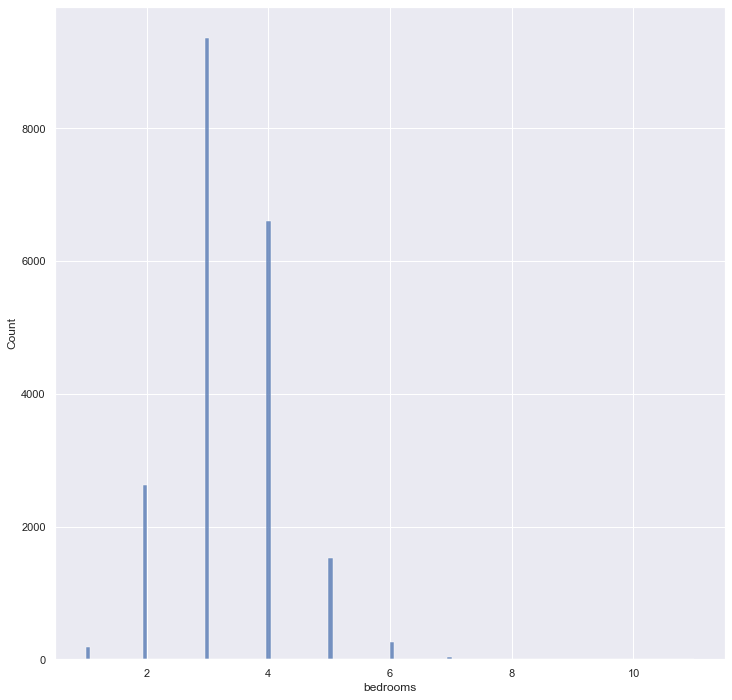

In [101]:
#lets explore some of our main variable and remove outliers
# we will look at bedrooms, bathroom, sqft_living, price and floors
display(df_initial.bedrooms.value_counts(), df_initial.bedrooms.describe())
sns.histplot(data= df_initial, x='bedrooms')
#1-6

In [103]:
display(df_initial.bathrooms.value_counts(), df_initial.bathrooms.describe())

2.50    5060
1.00    3699
1.75    2925
2.25    1984
2.00    1858
1.50    1385
2.75    1127
3.00     721
3.50     685
3.25     556
3.75     150
4.00     132
4.50      96
4.25      76
0.75      63
4.75      22
5.00      20
5.25      12
5.50       9
1.25       9
6.00       6
5.75       4
0.50       4
6.25       2
8.00       2
6.75       2
6.50       2
7.75       1
7.50       1
Name: bathrooms, dtype: int64

count   20613.00
mean        2.11
std         0.77
min         0.50
25%         1.50
50%         2.25
75%         2.50
max         8.00
Name: bathrooms, dtype: float64

In [126]:
def cap_bath(row):
    for bathroom in row['bathrooms']: 
        x=round(row['bathrooms'], 0)
        row['bathrooms']=x
           
    return row

In [127]:
cap_bath(df_initial)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,City
0,221900.00,3,1.00,1180,5650,1.00,0.00,0.00,3,7,1180,0.00,1955,1955,98178,47.51,-122.26,1340,5650,Seattle
1,538000.00,3,2.00,2570,7242,2.00,0.00,0.00,3,7,2170,400.00,1951,1991,98125,47.72,-122.32,1690,7639,Seattle
2,180000.00,2,1.00,770,10000,1.00,0.00,0.00,3,6,770,0.00,1933,1933,98028,47.74,-122.23,2720,8062,Kenmore
3,604000.00,4,3.00,1960,5000,1.00,0.00,0.00,5,7,1050,910.00,1965,1965,98136,47.52,-122.39,1360,5000,Seattle
4,510000.00,3,2.00,1680,8080,1.00,0.00,0.00,3,8,1680,0.00,1987,1987,98074,47.62,-122.05,1800,7503,Sammamish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.00,3,2.00,1530,1131,3.00,0.00,0.00,3,8,1530,0.00,2009,2009,98103,47.70,-122.35,1530,1509,Seattle
21593,400000.00,4,2.00,2310,5813,2.00,0.00,0.00,3,8,2310,0.00,2014,2014,98146,47.51,-122.36,1830,7200,Seattle
21594,402101.00,2,1.00,1020,1350,2.00,0.00,0.00,3,7,1020,0.00,2009,2009,98144,47.59,-122.30,1020,2007,Seattle
21595,400000.00,3,2.00,1600,2388,2.00,0.00,0.00,3,8,1600,0.00,2004,2004,98027,47.53,-122.07,1410,1287,Issaquah


In [128]:
display(df_initial.bathrooms.value_counts(), df_initial.bathrooms.describe())
#now bathrooms look cleaner we select 1-5


2.00    13212
1.00     3771
3.00     2404
4.00     1139
5.00       54
6.00       23
0.00        4
8.00        4
7.00        2
Name: bathrooms, dtype: int64

count   20613.00
mean        2.06
std         0.75
min         0.00
25%         2.00
50%         2.00
75%         2.00
max         8.00
Name: bathrooms, dtype: float64

In [129]:
# lets look at squarefoot living
display(df_initial.sqft_living.value_counts(), df_initial.sqft_living.describe())


1440    131
1400    130
1300    130
1660    126
1820    124
       ... 
6900      1
6980      1
3078      1
7220      1
2031      1
Name: sqft_living, Length: 1005, dtype: int64

count   20613.00
mean     2076.15
std       917.76
min       370.00
25%      1420.00
50%      1910.00
75%      2540.00
max     13540.00
Name: sqft_living, dtype: float64

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

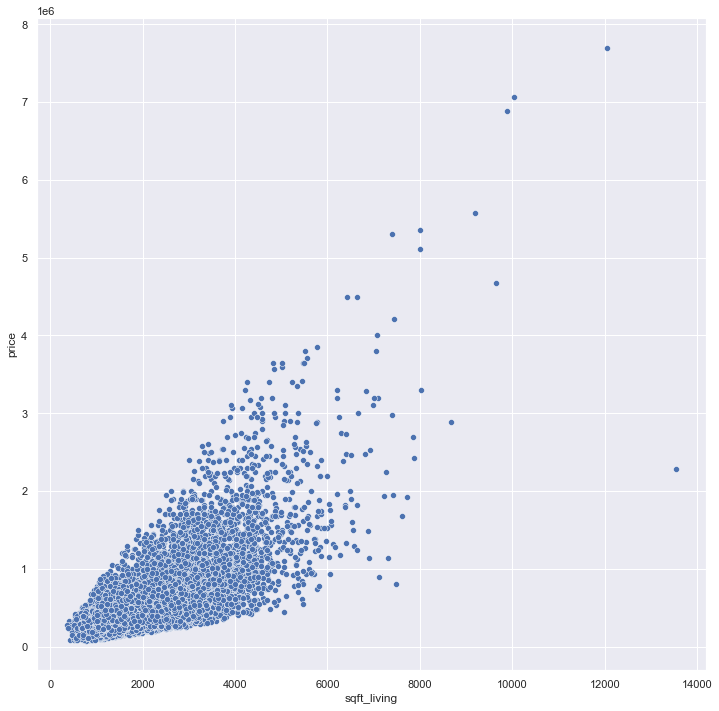

In [130]:
# we have decided to limit sqft < 4500
sns.scatterplot(x=df_initial['sqft_living'], y=df_initial['price'])

In [131]:
display(df_initial.price.value_counts(), df_initial.price.describe())

350000.00    164
450000.00    162
550000.00    147
500000.00    146
325000.00    142
            ... 
643403.00      1
882990.00      1
688100.00      1
300523.00      1
897000.00      1
Name: price, Length: 3522, dtype: int64

count     20613.00
mean     541582.60
std      372539.02
min       78000.00
25%      320000.00
50%      450000.00
75%      649950.00
max     7700000.00
Name: price, dtype: float64

914121.62 169043.57999999996


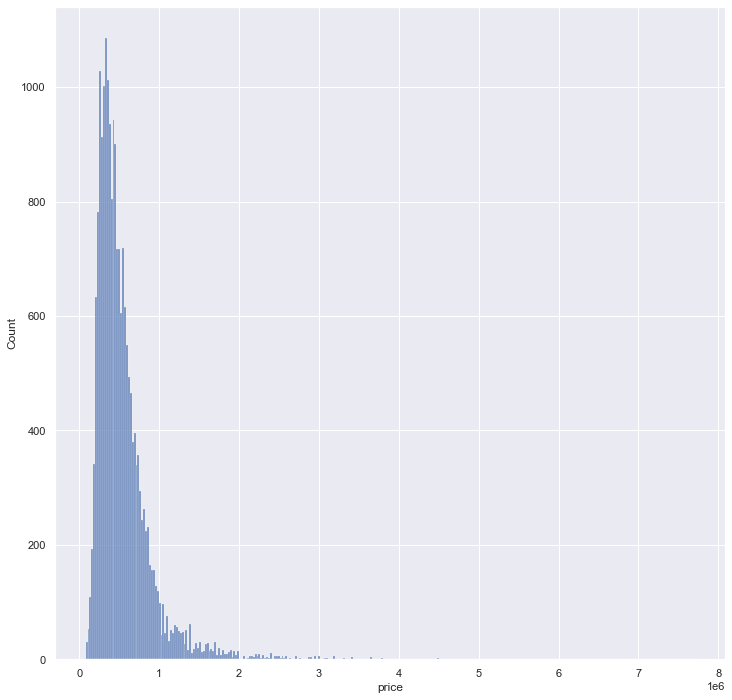

In [137]:
#will limit range of our price to 2 sd of the data
sns.histplot(data= df_initial, x='price')
mean= 541582.60
std = 372539.02
upper_bound_price= mean + std
lower_bound_price= mean - std

print(upper_bound_price, lower_bound_price)

#~ 915k - $170k

In [139]:
display(df_initial.floors.value_counts(), df_initial.floors.describe())

1.00    10310
2.00     7738
1.50     1809
3.00      595
2.50      155
3.50        6
Name: floors, dtype: int64

count   20613.00
mean        1.49
std         0.54
min         1.00
25%         1.00
50%         1.00
75%         2.00
max         3.50
Name: floors, dtype: float64

In [140]:
# going to keep it at 2 (domain knowledge)

df_initial2=df_initial
df_initial2 = pd.concat([df_initial2, df_second_r], axis=1)

In [142]:
df_initial2 = df_initial2.loc[:,~df_initial2.columns.duplicated()]

In [143]:
df_initial2

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,City,Condition 2,Condition 3,Condition 4,Condition 5,View 1,View 2,View 3,View 4,Grade 4,Grade 5,Grade 6,Grade 7,Grade 8,Grade 9,Grade 10,Grade 11,Grade 12,Grade 13,age,renovated,top25_neighborhood,sqft_living yr_renovated,sqft_living sqft_above,bathrooms sqft_above
0,221900.00,3,1.00,1180,5650,1.00,0.00,0.00,3,7,1180,0.00,1955,1955,98178,47.51,-122.26,1340,5650,Seattle,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,66,1,0,-0.98,-0.66,-0.86
1,538000.00,3,2.00,2570,7242,2.00,0.00,0.00,3,7,2170,400.00,1951,1991,98125,47.72,-122.32,1690,7639,Seattle,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,70,1,0,0.55,0.27,0.20
2,180000.00,2,1.00,770,10000,1.00,0.00,0.00,3,6,770,0.00,1933,1933,98028,47.74,-122.23,2720,8062,Kenmore,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,88,1,0,-1.42,-0.83,-0.98
3,604000.00,4,3.00,1960,5000,1.00,0.00,0.00,5,7,1050,910.00,1965,1965,98136,47.52,-122.39,1360,5000,Seattle,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,56,1,0,-0.14,-0.51,-0.30
4,510000.00,3,2.00,1680,8080,1.00,0.00,0.00,3,8,1680,0.00,1987,1987,98074,47.62,-122.05,1800,7503,Sammamish,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,34,1,1,-0.42,-0.34,-0.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.00,3,2.00,1530,1131,3.00,0.00,0.00,3,8,1530,0.00,2009,2009,98103,47.70,-122.35,1530,1509,Seattle,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,12,1,0,-0.56,-0.45,-0.11
21593,400000.00,4,2.00,2310,5813,2.00,0.00,0.00,3,8,2310,0.00,2014,2014,98146,47.51,-122.36,1830,7200,Seattle,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,7,1,0,0.30,0.22,0.45
21594,402101.00,2,1.00,1020,1350,2.00,0.00,0.00,3,7,1020,0.00,2009,2009,98144,47.59,-122.30,1020,2007,Seattle,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,12,1,0,-1.12,-0.73,-0.98
21595,400000.00,3,2.00,1600,2388,2.00,0.00,0.00,3,8,1600,0.00,2004,2004,98027,47.53,-122.07,1410,1287,Issaquah,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,17,1,1,-0.49,-0.40,-0.06


In [238]:
df_test2= df_initial2[(df_initial2.bedrooms <=5) & 
                      (df_initial2.sqft_living <=4500) & 
                      (df_initial2.floors <=2) & 
                      ((df_initial2.price <= 1400000) & (df_initial2.price >= lower_bound_price-100000))]

In [239]:
df_test2

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,City,Condition 2,Condition 3,Condition 4,Condition 5,View 1,View 2,View 3,View 4,Grade 4,Grade 5,Grade 6,Grade 7,Grade 8,Grade 9,Grade 10,Grade 11,Grade 12,Grade 13,age,renovated,top25_neighborhood,sqft_living yr_renovated,sqft_living sqft_above,bathrooms sqft_above
0,221900.00,3,1.00,1180,5650,1.00,0.00,0.00,3,7,1180,0.00,1955,1955,98178,47.51,-122.26,1340,5650,Seattle,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,66,1,0,-0.98,-0.66,-0.86
1,538000.00,3,2.00,2570,7242,2.00,0.00,0.00,3,7,2170,400.00,1951,1991,98125,47.72,-122.32,1690,7639,Seattle,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,70,1,0,0.55,0.27,0.20
2,180000.00,2,1.00,770,10000,1.00,0.00,0.00,3,6,770,0.00,1933,1933,98028,47.74,-122.23,2720,8062,Kenmore,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,88,1,0,-1.42,-0.83,-0.98
3,604000.00,4,3.00,1960,5000,1.00,0.00,0.00,5,7,1050,910.00,1965,1965,98136,47.52,-122.39,1360,5000,Seattle,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,56,1,0,-0.14,-0.51,-0.30
4,510000.00,3,2.00,1680,8080,1.00,0.00,0.00,3,8,1680,0.00,1987,1987,98074,47.62,-122.05,1800,7503,Sammamish,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,34,1,1,-0.42,-0.34,-0.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,475000.00,3,2.00,1310,1294,2.00,0.00,0.00,3,8,1180,130.00,2008,2008,98116,47.58,-122.41,1330,1265,Seattle,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,13,1,1,-0.80,-0.62,-0.36
21593,400000.00,4,2.00,2310,5813,2.00,0.00,0.00,3,8,2310,0.00,2014,2014,98146,47.51,-122.36,1830,7200,Seattle,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,7,1,0,0.30,0.22,0.45
21594,402101.00,2,1.00,1020,1350,2.00,0.00,0.00,3,7,1020,0.00,2009,2009,98144,47.59,-122.30,1020,2007,Seattle,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,12,1,0,-1.12,-0.73,-0.98
21595,400000.00,3,2.00,1600,2388,2.00,0.00,0.00,3,8,1600,0.00,2004,2004,98027,47.53,-122.07,1410,1287,Issaquah,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,17,1,1,-0.49,-0.40,-0.06


In [240]:
df_test2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18913 entries, 0 to 21596
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   price                     18913 non-null  float64
 1   bedrooms                  18913 non-null  int64  
 2   bathrooms                 18913 non-null  float64
 3   sqft_living               18913 non-null  int64  
 4   sqft_lot                  18913 non-null  int64  
 5   floors                    18913 non-null  float64
 6   waterfront                18913 non-null  float64
 7   view                      18913 non-null  float64
 8   condition                 18913 non-null  int64  
 9   grade                     18913 non-null  int64  
 10  sqft_above                18913 non-null  int64  
 11  sqft_basement             18517 non-null  float64
 12  yr_built                  18913 non-null  int64  
 13  yr_renovated              18913 non-null  int64  
 14  zipcod

In [241]:
df_test2['sqft_basement'].fillna(0, inplace= True)

In [244]:

y2 = df_test2['price']
x2 = df_test2.drop(['price','City','view','condition', 'sqft_lot', 'waterfront', 'grade', 
                    'sqft_above', 'sqft_basement','yr_renovated', 'zipcode', 'sqft_lot15', 'long', 'sqft_living15'], axis=1)
model5 = sm.OLS(y2, sm.add_constant(x2)).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     2219.
Date:                Tue, 13 Jul 2021   Prob (F-statistic):               0.00
Time:                        17:42:44   Log-Likelihood:            -2.4740e+05
No. Observations:               18913   AIC:                         4.949e+05
Df Residuals:                   18885   BIC:                         4.951e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
bedrooms                 -8045.6516   1365.911     -5.890      0.000   -1.07e+04   -5368.344
bathrooms                 1.868e+04   2575.014      7.253      0.000    1.36e+04    2.37e+04
sqft_living               -250.5414     67.239     -3.726      0.000    -382.336    -118.747
floors                    2.427e+04   2554.913      9.499      0.000    1.93e+04    2.93e+04
yr_built                 -9061.5135    179.807    -50.396      0.000   -9413.951   -8709.076
lat                           4e+05   6747.300     59.279      0.000    3.87e+05    4.13e+05
Condition 2               6.586e+04   2.56e+04      2.569      0.010    1.56e+04    1.16e+05
Condition 3               8.966e+04    2.4e+04      3.737      0.000    4.26e+04    1.37e+05
Condition 4               1.098e+05    2.4e+04      4.574      0.000    6.27e+04    1.57e+05
Condition 5               1.437e+05   2.41e+04      5.953      0.000    9.64e+04    1.91e+05
View 1                    9.123e+04   7114.503     12.823      0.000    7.73e+04    1.05e+05
View 2                    8.209e+04   4403.612     18.642      0.000    7.35e+04    9.07e+04
View 3                    1.379e+05   6381.758     21.607      0.000    1.25e+05     1.5e+05
View 4                    2.661e+05   9542.307     27.888      0.000    2.47e+05    2.85e+05
Grade 4                  -1.178e+05   1.18e+05     -0.995      0.320    -3.5e+05    1.14e+05
Grade 5                  -1.131e+05   1.17e+05     -0.971      0.332   -3.42e+05    1.15e+05
Grade 6                  -8.749e+04   1.16e+05     -0.752      0.452   -3.15e+05     1.4e+05
Grade 7                  -3.561e+04   1.16e+05     -0.306      0.760   -2.64e+05    1.92e+05
Grade 8                   2.673e+04   1.16e+05      0.230      0.818   -2.01e+05    2.55e+05
Grade 9                   1.269e+05   1.16e+05      1.090      0.276   -1.01e+05    3.55e+05
Grade 10                  1.982e+05   1.16e+05      1.702      0.089   -3.01e+04    4.27e+05
Grade 11                  3.121e+05   1.17e+05      2.672      0.008    8.32e+04    5.41e+05
Grade 12                   4.23e+05   1.25e+05      3.396      0.001    1.79e+05    6.67e+05
Grade 13                   1.31e-10   1.75e-10      0.750      0.453   -2.11e-10    4.73e-10
age                      -7011.1915    214.602    -32.671      0.000   -7431.831   -6590.552
renovated                   -7.9528      0.193    -41.165      0.000      -8.332      -7.574
top25_neighborhood        1.361e+05   2067.276     65.824      0.000    1.32e+05     1.4e+05
sqft_living yr_renovated  3.282e+05    6.3e+04      5.207      0.000    2.05e+05    4.52e+05
sqft_living sqft_above   -2.078e+04   6772.560     -3.069      0.002   -3.41e+04   -7508.337
bathrooms sqft_above      2.375e+04   5698.453      4.168      0.000    1.26e+04    3.49e+04
==============

In [252]:
y2 = df_test2['price']
x2 = df_test2.drop(['price','City'], axis=1)
model5 = sm.OLS(y2, sm.add_constant(x2)).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     1759.
Date:                Tue, 13 Jul 2021   Prob (F-statistic):               0.00
Time:                        17:47:05   Log-Likelihood:            -2.4700e+05
No. Observations:               18913   AIC:                         4.941e+05
Df Residuals:                   18876   BIC:                         4.944e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
bedrooms                 -7627.8118   1356.725     -5.622      0.000   -1.03e+04   -4968.510
bathrooms                 1.474e+04   2726.094      5.408      0.000    9399.908    2.01e+04
sqft_living                317.0225    103.770      3.055      0.002     113.624     520.421
sqft_lot                     0.2553      0.031      8.330      0.000       0.195       0.315
floors                     2.43e+04   2641.793      9.198      0.000    1.91e+04    2.95e+04
waterfront                2.166e+05   1.96e+04     11.068      0.000    1.78e+05    2.55e+05
view                      4.437e+04   1642.919     27.006      0.000    4.11e+04    4.76e+04
condition                 4.293e+04   7581.811      5.662      0.000    2.81e+04    5.78e+04
grade                     1.509e+04    1.8e+04      0.839      0.402   -2.02e+04    5.04e+04
sqft_above                  -3.6837     12.852     -0.287      0.774     -28.875      21.508
sqft_basement                5.8340     11.784      0.495      0.621     -17.263      28.932
yr_built                 -1.058e+04    907.138    -11.664      0.000   -1.24e+04   -8803.066
yr_renovated               945.3453    127.428      7.419      0.000     695.574    1195.116
zipcode                   -252.1717     20.424    -12.347      0.000    -292.204    -212.140
lat                       4.171e+05   6929.014     60.194      0.000    4.04e+05    4.31e+05
long                     -1.952e+05   8743.255    -22.321      0.000   -2.12e+05   -1.78e+05
sqft_living15               27.6869      2.293     12.076      0.000      23.193      32.181
sqft_lot15                  -0.0568      0.049     -1.152      0.249      -0.153       0.040
Condition 2               4.088e+04   1.82e+04      2.252      0.024    5300.642    7.65e+04
Condition 3                 2.1e+04   8489.501      2.473      0.013    4355.641    3.76e+04
Condition 4              -2653.5907   2002.407     -1.325      0.185   -6578.488    1271.307
Condition 5              -7993.7102   7090.136     -1.127      0.260   -2.19e+04    5903.593
View 1                    3.598e+04   6868.439      5.238      0.000    2.25e+04    4.94e+04
View 2                    -1.35e+04   4707.934     -2.867      0.004   -2.27e+04   -4267.500
View 3                   -6223.1539   6049.234     -1.029      0.304   -1.81e+04    5633.888
View 4                    1.351e+04   5836.316      2.315      0.021    2073.007     2.5e+04
Grade 4                  -1.732e+05   9.85e+04     -1.758      0.079   -3.66e+05    1.99e+04
Grade 5                  -1.833e+05   7.85e+04     -2.336      0.019   -3.37e+05   -2.95e+04
Grade 6                  -1.797e+05   6.03e+04     -2.978      0.003   -2.98e+05   -6.14e+04
Grade 7                   -1.54e+05   4.27e+04     -3.608      0.000   -2.38e+05   -7.03e+04
Grade 8       

In [245]:
x_variables = ['Grade 6','Grade 7','Grade 8','Grade 9','Grade 10', 
                                   'Condition 2', 'Condition 3', 'Condition 4', 'Condition 5']
df_x= df_test2[x_variables]


model5 = sm.OLS(y2, sm.add_constant(df_x)).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     1337.
Date:                Tue, 13 Jul 2021   Prob (F-statistic):               0.00
Time:                        17:43:36   Log-Likelihood:            -2.5626e+05
No. Observations:               18913   AIC:                         5.125e+05
Df Residuals:                   18903   BIC:                         5.126e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.358e+05   3.83e+04     11.393      0.000    3.61e+05    5.11e+05
Grade 6     -2.935e+05      1e+04    -29.305      0.000   -3.13e+05   -2.74e+05
Grade 7     -1.924e+05   9324.651    -20.630      0.000   -2.11e+05   -1.74e+05
Grade 8     -4.836e+04   9460.003     -5.112      0.000   -6.69e+04   -2.98e+04
Grade 9      1.434e+05   9948.958     14.412      0.000    1.24e+05    1.63e+05
Grade 10     3.013e+05   1.12e+04     26.822      0.000    2.79e+05    3.23e+05
Condition 2  5.909e+04   4.08e+04      1.448      0.148   -2.09e+04    1.39e+05
Condition 3  1.311e+05   3.81e+04      3.442      0.001    5.65e+04    2.06e+05
Condition 4  1.747e+05   3.81e+04      4.581      0.000    9.99e+04    2.49e+05
Condition 5  2.486e+05   3.83e+04      6.484      0.000    1.73e+05    3.24e+05
==============================================================================
Omnibus:                     2655.601   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5102.163
Skew:                           0.888   Prob(JB):                         0.00
Kurtosis:                       4.822   Cond. No.                         85.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [154]:
df_test2.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Condition 2,Condition 3,Condition 4,Condition 5,View 1,View 2,View 3,View 4,Grade 4,Grade 5,Grade 6,Grade 7,Grade 8,Grade 9,Grade 10,Grade 11,Grade 12,Grade 13,age,renovated,top25_neighborhood,sqft_living yr_renovated,sqft_living sqft_above,bathrooms sqft_above
price,1.00,0.26,0.36,0.56,0.09,0.26,0.04,0.19,0.03,0.58,0.46,0.20,0.03,0.06,-0.01,0.47,0.09,0.52,0.09,-0.06,0.01,-0.03,0.05,0.08,0.12,0.09,0.08,-0.03,-0.09,-0.27,-0.30,0.19,0.34,0.28,0.10,NaN,NaN,-0.03,NaN,0.57,0.56,0.52,0.48
bedrooms,0.26,1.00,0.45,0.60,0.03,0.23,-0.01,0.02,0.01,0.33,0.47,0.25,0.22,0.21,-0.17,-0.07,0.16,0.39,0.03,-0.04,0.01,-0.01,0.01,0.01,0.01,0.02,0.00,-0.06,-0.10,-0.25,-0.09,0.13,0.17,0.09,0.03,NaN,NaN,-0.22,NaN,0.05,0.59,0.49,0.50
bathrooms,0.36,0.45,1.00,0.61,0.06,0.34,-0.00,0.08,-0.06,0.48,0.48,0.28,0.41,0.43,-0.16,-0.03,0.19,0.42,0.07,-0.06,0.11,-0.10,-0.00,0.03,0.05,0.06,0.01,-0.04,-0.12,-0.34,-0.17,0.22,0.22,0.18,0.05,NaN,NaN,-0.41,NaN,0.11,0.62,0.52,0.69
sqft_living,0.56,0.60,0.61,1.00,0.15,0.42,0.01,0.13,-0.09,0.69,0.84,0.34,0.39,0.40,-0.21,-0.02,0.30,0.73,0.18,-0.06,0.12,-0.09,-0.05,0.05,0.07,0.09,0.04,-0.05,-0.12,-0.35,-0.34,0.23,0.40,0.32,0.11,NaN,NaN,-0.39,NaN,0.16,1.00,0.91,0.85
sqft_lot,0.09,0.03,0.06,0.15,1.00,-0.00,0.01,0.09,-0.00,0.09,0.15,0.00,0.05,0.05,-0.13,-0.09,0.26,0.15,0.70,0.04,-0.02,0.02,-0.01,-0.01,0.04,0.10,0.02,0.00,0.03,-0.02,-0.07,0.00,0.06,0.09,0.01,NaN,NaN,-0.05,NaN,-0.02,0.15,0.17,0.13
floors,0.26,0.23,0.34,0.42,-0.00,1.00,-0.01,-0.03,-0.27,0.47,0.62,-0.31,0.50,0.50,-0.14,-0.06,0.23,0.36,0.00,-0.04,0.31,-0.25,-0.13,-0.03,-0.03,-0.01,-0.00,-0.02,-0.07,-0.21,-0.29,0.21,0.30,0.18,0.05,NaN,NaN,-0.50,NaN,0.09,0.43,0.54,0.64
waterfront,0.04,-0.01,-0.00,0.01,0.01,-0.01,1.00,0.23,-0.01,-0.00,-0.01,0.03,-0.03,-0.02,0.05,-0.03,-0.03,0.02,0.01,-0.00,-0.00,0.00,-0.01,-0.00,-0.01,-0.00,0.52,-0.00,0.01,0.00,-0.01,0.00,-0.00,0.00,-0.00,NaN,NaN,0.03,NaN,-0.02,0.01,-0.01,-0.01
view,0.19,0.02,0.08,0.13,0.09,-0.03,0.23,1.00,0.02,0.09,0.03,0.17,-0.08,-0.07,0.11,-0.03,-0.07,0.16,0.09,-0.01,-0.03,0.03,0.01,0.17,0.62,0.60,0.44,0.01,-0.00,-0.03,-0.08,0.06,0.07,0.02,0.01,NaN,NaN,0.08,NaN,-0.02,0.12,0.07,0.04
condition,0.03,0.01,-0.06,-0.09,-0.00,-0.27,-0.01,0.02,1.00,-0.19,-0.19,0.17,-0.35,-0.37,0.01,-0.00,-0.10,-0.14,-0.01,-0.19,-0.86,0.55,0.71,0.02,0.02,0.01,-0.00,0.00,0.03,0.07,0.12,-0.07,-0.13,-0.08,-0.03,NaN,NaN,0.35,NaN,-0.00,-0.11,-0.17,-0.20
grade,0.58,0.33,0.48,0.69,0.09,0.47,-0.00,0.09,-0.19,1.00,0.69,0.04,0.50,0.50,-0.21,0.04,0.27,0.67,0.11,-0.07,0.22,-0.15,-0.12,0.02,0.05,0.06,0.03,-0.10,-0.25,-0.51,-0.45,0.35,0.54,0.46,0.19,NaN,NaN,-0.50,NaN,0.28,0.70,0.70,0.71
